# Topic2. Real robot path search


## 2-1. Import python package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
import numpy as np
from collections import defaultdict, deque, Counter
from itertools import combinations

In [2]:
MAP_RANGE = (10, 10)

## 2-2. Problem abstract & State-space tree node & queue

In [3]:
class Problem(object):
    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    def __str__(self):
        return '{}({}, {})'.format(type(self).__name__, self.initial, self.goal)
    
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)
    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
failure = Node('failure', path_cost=float('inf')) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=float('inf')) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
    
def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

<font color="red">
    
## 2-3. Grid Problem for fixed map

</font>

We define a `GridProblem` class here to present a problem has an initial point, a goal point, obstacles and other limitations. Assume a robot is locate on initial point, you need to use search method to plan a path and avoid robot bump into the wall.

In [4]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""
    
    def __init__(self, initial=(0.8, 0.8), goal=(1.5, 7.2), obstacles=(),
                 grid_size=0.2, veh_size=(0.6, 0.6), map_range=MAP_RANGE, **kwds):
        
        Problem.__init__(self, initial=initial, goal=goal, obstacles=set(obstacles) - {initial},
                         grid_size=grid_size, veh_size=veh_size, map_range=map_range, **kwds)
        
        # inline function
        self.to_grid = lambda state: (int(state[0]*10/self.grid_size/10), int(state[1]*10/self.grid_size/10))
        
        self.directions = [(0, -1), (-1, 0), (1,  0), (0, +1)]
        
        self.gridmap = set()
        
        self.generate_gridmap()
        
        if not self.is_state_safe(self.goal):
            raise ValueError('goal:{} is invaild, it could not be set in obstacle\n or out of range {}~{} m'.format( self.goal, self.veh_size, \
                                (self.map_range[0]-self.veh_size[0], self.map_range[1]-self.veh_size[1])))
        
    
    def is_state_safe(self, state):
        if state[0] < self.veh_size[0] or state[0] > self.map_range[0]-self.veh_size[0] or \
            state[1] < self.veh_size[1] or state[1] > self.map_range[1]-self.veh_size[1]:
            return False
        elif self.to_grid(state) in self.gridmap:
            return False
        else:    return True
    
    def generate_gridmap(self):
        for p in self.obstacles:
            self.gridmap.add(self.to_grid(p))
            
        # Remove initial point point from grid map
        self.gridmap = self.gridmap - {self.to_grid(self.initial)}
            
    def step_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        result_grid_loc = self.to_grid(state)
        return action if action not in self.gridmap else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        grid_p = self.to_grid(state)
        action_list = []
        for (dx, dy) in self.directions:
            next_p = (grid_p[0]+dx, grid_p[1]+dy)
            if next_p not in self.gridmap:
                action_list.append((round(next_p[0]*self.grid_size + 0.5*self.grid_size, 3), \
                                    round(next_p[1]*self.grid_size + 0.5*self.grid_size, 3)))
        return action_list
    
    def is_goal(self, state):
        return self.to_grid(state) == self.to_grid(self.goal)


## 2-4. Obstacle generator

This section is prepared for obstacle generator. Note that we use `yield` to create iterable variable, then use `set()` to include all elements in the grid problem. If you want to know more about `yield`, please ask TA or visit [Stackflew](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do) or [Chinese intro](https://liam.page/2017/06/30/understanding-yield-in-python/).

In [5]:
def transpose(matrix): return list(zip(*matrix))

# The following can be used to create obstacles:
def straight_line_distance(point1, point2):
    "Straight-line distance between two 2D points."
    return abs(complex(*point1) - complex(*point2))
            
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in np.arange(0, length*1.001, 0.01)}

def add_block(x, y, len_x, len_y):
    for obj_line in line(x, y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y+len_y, 1, 0, len_x):
        yield obj_line
    for obj_line in line(x, y, 0, 1, len_y):
        yield obj_line
    for obj_line in line(x+len_x, y, 0, 1, len_y):
        yield obj_line

def fixed_map(obs_list=None, obs_size=(0.25, 0.25)):
    for obj_line in add_block(x=0, y=0, len_x=MAP_RANGE[0]-0.2, len_y=MAP_RANGE[1]-0.2):
        yield obj_line
        
    # duckiebot field
    for obj_line in add_block(x=3.5, y=2.0, len_x=2.6, len_y=3.8):
        yield obj_line
        
    for obj_line in add_block(x=0.0, y=0.0, len_x=2.1, len_y=9.8):
        yield obj_line
    for obj_line in add_block(x=7.7, y=0.0, len_x=2.1, len_y=9.8):
        yield obj_line

#     # center watchtower 1
#     for obj_line in add_block(x=0.6, y=1.0, len_x=1.0, len_y=0.4):
#         yield obj_line
    
#     # center watchtower 2
#     for obj_line in add_block(x=0.6, y=2.25, len_x=1.0, len_y=0.4):
#         yield obj_line
        
    # custom obstacles
    if obs_list != None:
        for obs in obs_list:
            for obj_line in add_block(x=obs[0]-obs_size[0]/2, y=obs[1]-obs_size[1]/2, \
                                          len_x=obs_size[0], len_y=obs_size[1]):
                yield obj_line
        

<font color="red">
    
## 2-5. Search methods
</font>

This section declare classic search algorithms to solve the problem defined above. Noted that we made a change in the code. `reached` variable need to be changed to global varible for storing the process of searching.

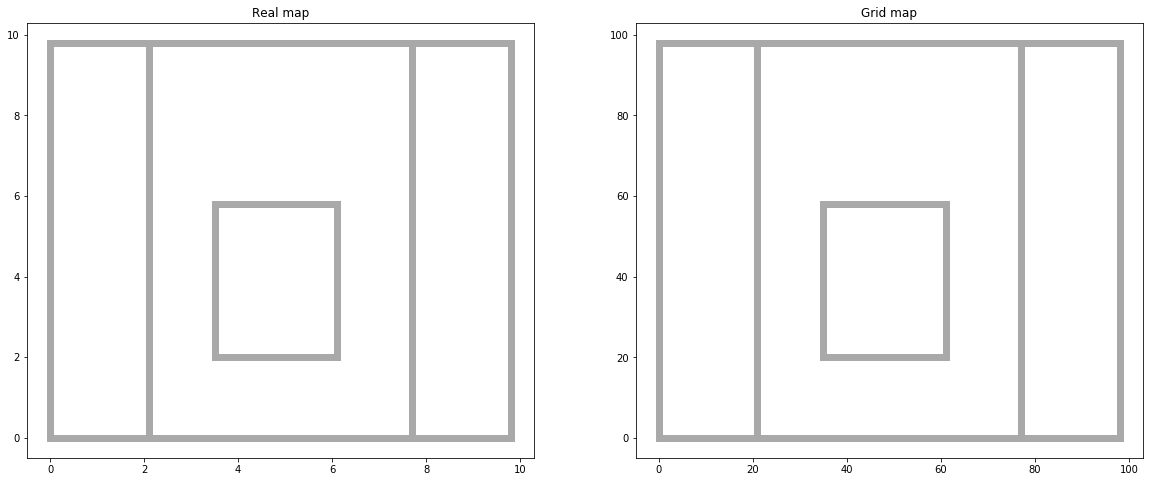

In [6]:
# Difference between real map and grid map
gp1 = GridProblem(grid_size=0.1, obstacles=fixed_map())

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.title('Real map')
obs_list = transpose(list(gp1.obstacles))
plt.scatter(obs_list[0], obs_list[1], marker='s', color='darkgrey')

plt.subplot(122)
plt.title('Grid map')
grid_list = transpose(list(gp1.gridmap))
plt.scatter(grid_list[0], grid_list[1], marker='s', color='darkgrey')
plt.show()

In [7]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

In [8]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    global reached # <<<<<<<<<<< Only change here
    reached = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

### Best-first search

Best-first search with various f(n) functions gives us different search algorithms. Note that A* can be given a heuristic function h, providing additional information for finding an approximate solution. but if h is not supplied they use the problem's default h function.

**THE MAIN MISSION TODAY**  is to difine a custom search algrithm to solve grid problem. You can actually expect the path result according to what information you provided. For example, `uniform_cost_search` cares more about `path_cost` that means you may pay lower cost (designed by yourself) from A point to B point.

In [9]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while len(frontier) != 0:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if (s not in reached) or (child.path_cost < reached[s].path_cost):
                reached[s] = child
                frontier.add(child)
    return failure


# It is also famous as Dijkstra's algorithm
def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)

# It is also famous as Dijkstra's algorithm
def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))

def custom_search(problem):
    global gp_global
    
    if problem != None: gp_global = problem
        
    """Search nodes with minimum f(node), you need to define a f(n) by some attributes from node"""
    return best_first_search(problem, f=custom_func)

def custom_func(node):
    global gp_global
    '''
    You can return any infomation you want to provide
    
    Hint:
    if you want to get heuristic value on specific node --> gp_global.h(node)
    if you want to get action_list on specific state    --> gp_global.actions(node.state)
    if you want to get previous state (need NoneValue check) --> node.parent.state
    if you want to get current x,y --> (x,y) = node.state
    if you want to current direction and previous direction 
        
    -->if node.parent != None and node.parent.parent != None:
        dir1 = tuple(np.subtract(node.parent.state, node.state))
        dir2 = tuple(np.subtract(node.parent.parent.state, node.parent.state))
        print(dir1, dir2)
    
    '''

    return node.path_cost 

## 2-6. Ploting function

Here we declare a ploting function to visialize problem and test some search algorithm. you can see difference of them.

In [10]:
def plot_grid_problem(grid_problem, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    
    # plot initial position and goal
    start = grid_problem.to_grid(grid_problem.initial)
    goal = grid_problem.to_grid(grid_problem.goal)
    plt.scatter(start[0], start[1], 11**2, marker='D', c='green')
    plt.scatter(goal[0], goal[1], 10**2, marker='D', c='red')
    plt.legend(['current_loc', 'goal_loc'])
    
    # plot obstacle
    obs_list = transpose(list(grid_problem.gridmap))
    if len(obs_list) != 0:
        plt.scatter(obs_list[0], obs_list[1], marker='s', color='darkgrey')
    
    # plot reached path
    reached_list = transpose([grid_problem.to_grid(point) for point in reached])
    if len(reached_list) != 0:
        plt.scatter(reached_list[0], reached_list[1], 1**2, marker='.', c='blue')
    
    # plot solution path
    traj_list = transpose([grid_problem.to_grid(point) for point in path_states(solution)])
    if len(traj_list) != 0:
        plt.scatter(traj_list[0], traj_list[1], marker='s', c='black')

    plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 30, title, solution.path_cost, len(reached)))

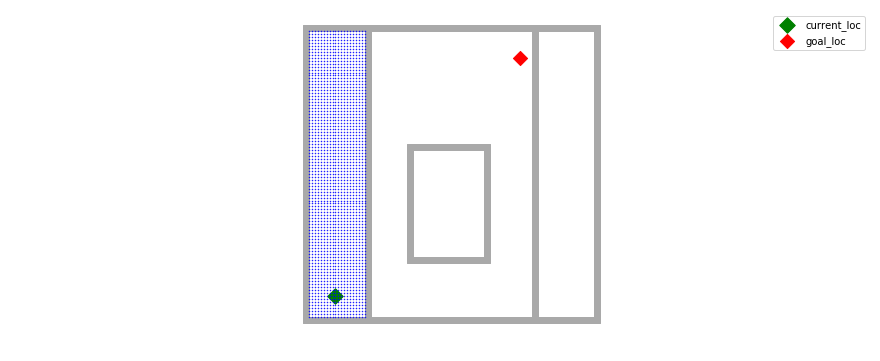

                               Breadth first search: inf path cost, 1,940 states reached


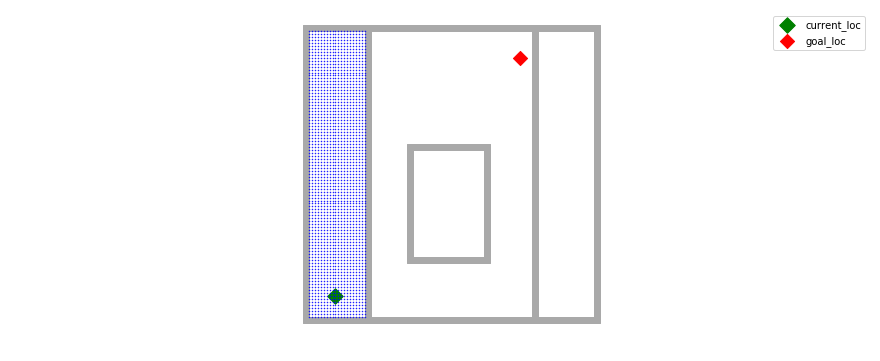

                               Dijkstra (Uniform cost) search: inf path cost, 1,940 states reached


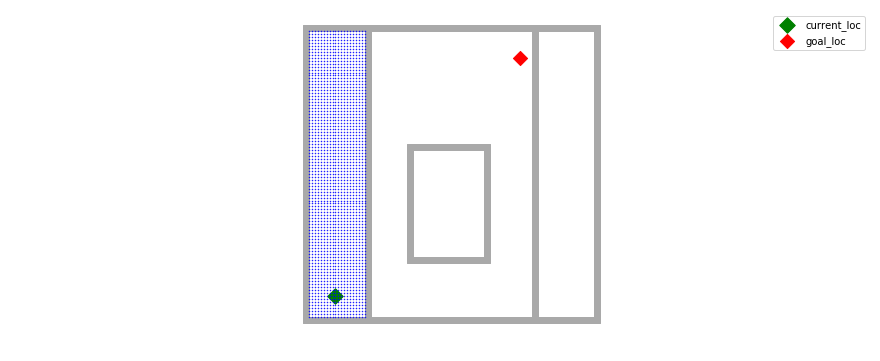

                               Custom algorithm search: inf path cost, 1,940 states reached


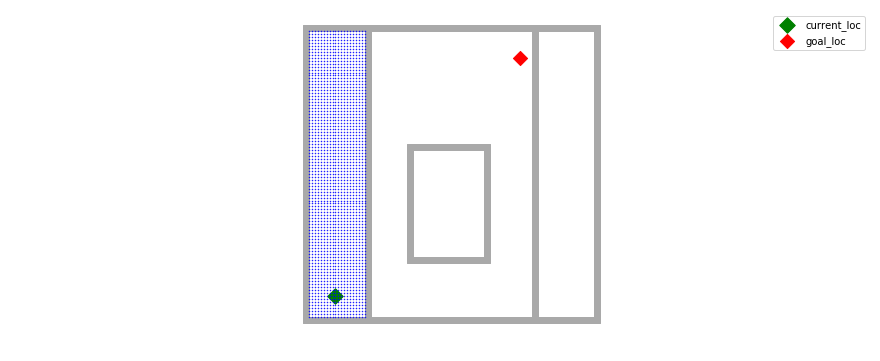

                               Custom algorithm search: inf path cost, 1,940 states reached


In [11]:
# Test algorithms on small map

gp1 = GridProblem(initial=(1.0, 0.8), goal=(7.2, 8.8), grid_size=0.1, obstacles=fixed_map())
sol1 = breadth_first_search(gp1)
plot_grid_problem(gp1, sol1, reached, title='Breadth first')

sol2 = uniform_cost_search(gp1)
plot_grid_problem(gp1, sol2, reached, title='Dijkstra (Uniform cost)')

sol3 = custom_search(gp1)
plot_grid_problem(gp1, sol3, reached, title='Custom algorithm')

sol4 = astar_search(gp1)
plot_grid_problem(gp1, sol3, reached, title='Custom algorithm')

<font color="red">
    
# ROS start here !!
</font>

This section is designed for **MMBOT DEMO**, we will infer some ROS concept for message communication from node to node. We don't cover all ROS tutorial in this course. So if you want to know more about ROS, we suggest you visit [CLEARPATH official tutorial](http://www.clearpathrobotics.com/assets/guides/ros/).

We also provide ROS keywords refered in this tutorial, you can google it if you are interested in it:
- ROS Master
- ROS Node
- ROS Message
- ROS Subscriber/Publisher
- ROS Package


### Import ROS related package

Compile laptop_ws first, this process will several python packages which we need. please wait here for a while.

In [12]:
%%bash
catkin_make -C ../laptop_ws
source ../laptop_ws/devel/setup.bash
export ROS_IP=$(hostname -I)

[  0%] Built target std_msgs_generate_messages_lisp
[  0%] Built target geometry_msgs_generate_messages_lisp
[  0%] Built target control_gencfg
[  0%] Built target sensor_msgs_generate_messages_lisp
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_ObstacleType
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_WheelsCmd
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_LanePose
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_CarControl
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_StopLineReading
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_Segment
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_GetVariable
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_WheelsCmdStamped
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_BoolStamped
[  0%] Built target _duckietown_msgs_generate_messages_check_deps_AprilTagsWithInfos
[  0%] Built t

In [13]:
import sys
sys.path.insert(0, '../laptop_ws/devel/lib/python2.7/dist-packages')

import os
import rospy
import tf

# Create path msh to mmbot
from nav_msgs.msg import Odometry, Path
from geometry_msgs.msg import PoseStamped

# Location msg from watch tower server
from duckietown_msgs.msg import Pose2DStamped, GlobalPoseArray

### ROS node initialization

In [14]:
# ROS_MASTER_URI must to be set
os.environ["ROS_MASTER_URI"] = "http://192.168.1.171:11311"


rospy.init_node("path_planning_node", anonymous = False)

# Bot name must to be set
BOT_NAME = "husky"                 
path_pub = rospy.Publisher('/planning_path', Path, queue_size=10)

### How to get the location message

In [15]:
# Set location infomation as global variable
global initial_point
initial_point = (0, 0)

global obs_list
obs_list = [(0, 0)] * 4

In [16]:
# def location_cb(msg):
#     global initial_point
#     global obs_list
    
#     initial_point = (0, 0)
    
#     for pose in msg.poses:
#         if pose.bot_id == 436 and BOT_NAME != "super_pi01": obs_list[0] = pose.pose.x, pose.pose.y
#         if pose.bot_id == 439 and BOT_NAME != "super_pi02": obs_list[1] = pose.pose.x, pose.pose.y
#         if pose.bot_id == 404 and BOT_NAME != "super_pi03": obs_list[2] = pose.pose.x, pose.pose.y
#         if pose.bot_id == 405 and BOT_NAME != "super_pi04": obs_list[3] = pose.pose.x, pose.pose.y
        
#         # id=436--> super_pi01,
#         # id=439--> super_pi02,
#         # id=404--> super_pi03,
#         # id=405--> super_pi04,`
#         if (BOT_NAME == "super_pi01" and pose.bot_id == 436) or \
#             (BOT_NAME == "super_pi02" and pose.bot_id == 439) or \
#             (BOT_NAME == "super_pi03" and pose.bot_id == 404) or \
#             (BOT_NAME == "super_pi04" and pose.bot_id == 405): 
#             initial_point = (pose.pose.x, pose.pose.y)
            
# loc_sub = rospy.Subscriber("/nctuece/pose_optimization/bot_global_poses_optimized", \
#                           data_class=GlobalPoseArray, \
#                           callback=location_cb)
def location_cb(msg):
    global initial_point
    global obs_list
    #print "location_cb"
    initial_point = msg.pose.position.x, msg.pose.position.y
    
            
loc_sub = rospy.Subscriber("/pozyx_node/local_tag_pose", \
                          data_class=PoseStamped, \
                          callback=location_cb)


In [17]:
%%bash
rostopic info /pozyx_node/local_tag_pose

Type: geometry_msgs/PoseStamped

Publishers: None

Subscribers: 
 * /path_planning_node (http://192.168.1.221 172.17.0.1 :42151/)




In [22]:
while initial_point == (0,0):
    print('didn\'t get location info')
    #rospy.spin()
    rospy.sleep(1)

print('Initial_point: {}'.format(initial_point))
print('Obstacle list: {}'.format(obs_list))

Initial_point: (3.883, 0.059)
Obstacle list: [(0, 0), (0, 0), (0, 0), (0, 0)]


### Solve the problem by custom search algorithm

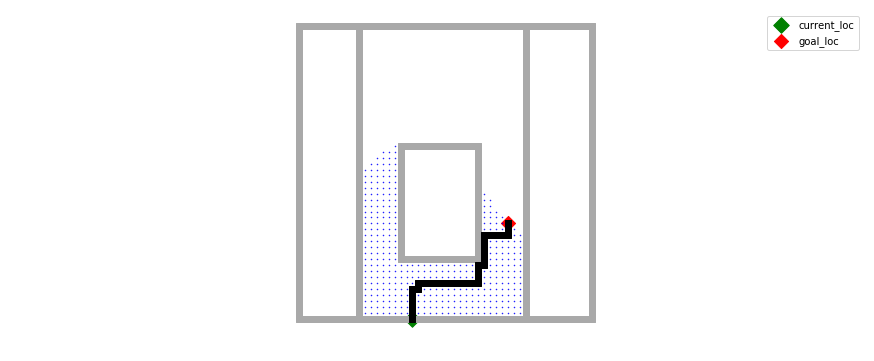

                               Search search: 6.4 path cost, 412 states reached


In [23]:
goal_point = (7.0, 3.2)
gp1 = GridProblem(initial=initial_point, goal=goal_point, grid_size=0.2, obstacles=fixed_map(obs_list=obs_list))
solution = custom_search(gp1)
plot_grid_problem(gp1, solution, reached)

### Publish the planning path to the robot

In [24]:
path = Path()
path.header.frame_id = 'map'
path.header.stamp = rospy.Time.now()

traj_list = list(path_states(solution))

print('planning trajectory:')
for a in traj_list: print(a)
    
for i in range(len(traj_list)-1) :
    p = PoseStamped()
    p.header.frame_id = 'map'
    p.header.stamp = rospy.Time.now()
    p.pose.position.x = traj_list[i][0]
    p.pose.position.y = traj_list[i][1]
    
    head_angle = math.atan2(traj_list[i+1][1] - traj_list[i][1],
                            traj_list[i+1][0] - traj_list[i][0])
#     print(p.pose.position.x, p.pose.position.y, head_angle*180.0/math.pi)
    
    (p.pose.orientation.x, p.pose.orientation.y, p.pose.orientation.z, p.pose.orientation.w) = tf.transformations.quaternion_from_euler(0, 0, math.pi)
    path.poses = path.poses + [p]

# publish path msg
# for i in range(10):
#     path_pub.publish(path)

planning trajectory:
(3.881, 0.073)
(3.9, 0.3)
(3.9, 0.5)
(3.9, 0.7)
(3.9, 0.9)
(3.9, 1.1)
(4.1, 1.1)
(4.1, 1.3)
(4.3, 1.3)
(4.5, 1.3)
(4.7, 1.3)
(4.9, 1.3)
(5.1, 1.3)
(5.3, 1.3)
(5.5, 1.3)
(5.7, 1.3)
(5.9, 1.3)
(6.1, 1.3)
(6.1, 1.5)
(6.1, 1.7)
(6.1, 1.9)
(6.3, 1.9)
(6.3, 2.1)
(6.3, 2.3)
(6.3, 2.5)
(6.3, 2.7)
(6.3, 2.9)
(6.5, 2.9)
(6.7, 2.9)
(6.9, 2.9)
(7.1, 2.9)
(7.1, 3.1)
(7.1, 3.3)


<font color="red">
    
   # Notice!!  
</font>

### The following code will run all process let robot move from point A to B.

In [25]:
def robot_navigate(goal_point):
    for i in range(200):
        while initial_point == (0, 0):
            pass

        print('Initial_point: {}'.format(initial_point))
        gp = GridProblem(initial=initial_point, goal=goal_point, grid_size=0.6, obstacles=fixed_map(obs_list=obs_list))
        solution = uniform_cost_search(gp)
        plot_grid_problem(gp, solution, reached)

        # Arrived goal
        if gp.to_grid(gp.initial) == gp.to_grid(gp.goal): break


        # Create path
        path = Path()
        path.header.frame_id = 'map'
        path.header.stamp = rospy.Time.now()
        traj_list = [p for p in list(path_states(solution))]

        print('=====================')
        print(initial_point)
        print(traj_list)

        for i in range(len(traj_list)) :
            p = PoseStamped()
            p.header.frame_id = 'map'
            p.header.stamp = rospy.Time.now()
            p.pose.position.x = traj_list[i][0]
            p.pose.position.y = traj_list[i][1]

            if i is len(traj_list)-1:
                p.pose.orientation = path.poses[-1].pose.orientation
            else: 
                head_angle = math.atan2(traj_list[i+1][1] - traj_list[i][1],
                                        traj_list[i+1][0] - traj_list[i][0])

            (p.pose.orientation.x, p.pose.orientation.y, p.pose.orientation.z, p.pose.orientation.w) = tf.transformations.quaternion_from_euler(0, 0, math.pi)
            path.poses = path.poses + [p]

        for i in range(5):
            path_pub.publish(path)

        rospy.sleep(duration=1)
    

In [26]:
%%bash
rostopic info /pursue_point

Type: geometry_msgs/PoseStamped

Publishers: 
 * /pure_pursuit_point (http://192.168.1.163:45539/)

Subscribers: 
 * /subt_pid (http://192.168.1.163:37655/)




Initial_point: (2.549, 2.69)


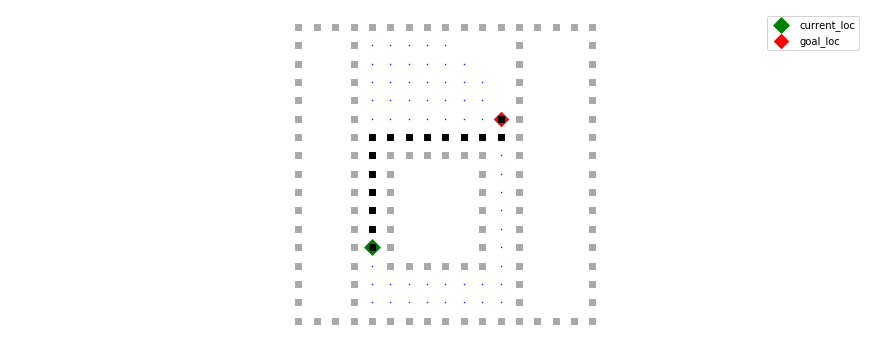

                               Search search: 8.4 path cost, 71 states reached
(2.549, 2.69)
[(2.549, 2.69), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.27, 2.708)


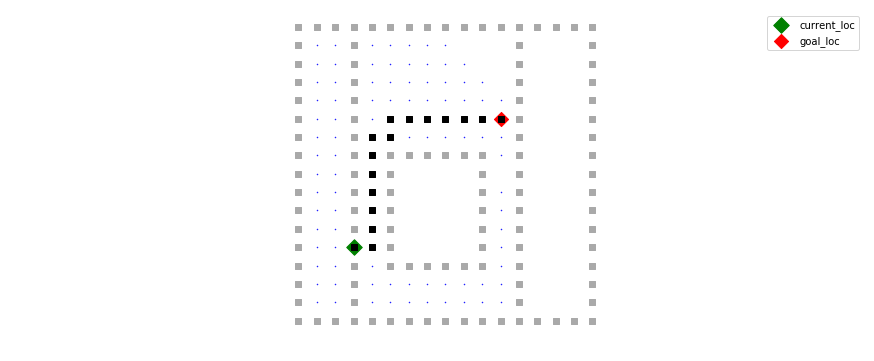

                               Search search: 8.8 path cost, 102 states reached
(2.302, 2.661)
[(2.27, 2.708), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.162, 2.475)


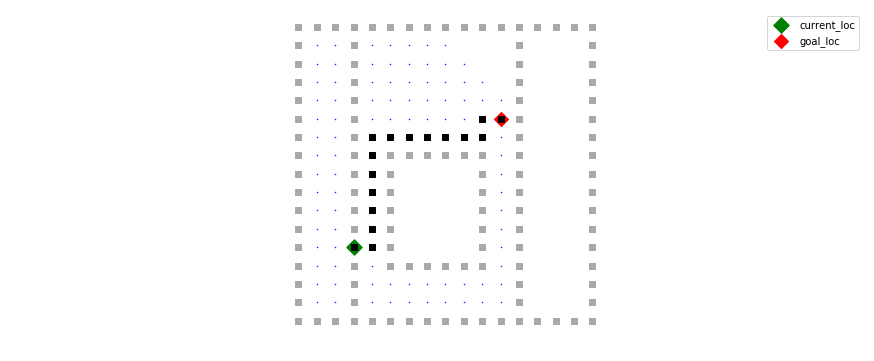

                               Search search: 9.0 path cost, 103 states reached
(2.324, 2.456)
[(2.162, 2.475), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.261, 2.501)


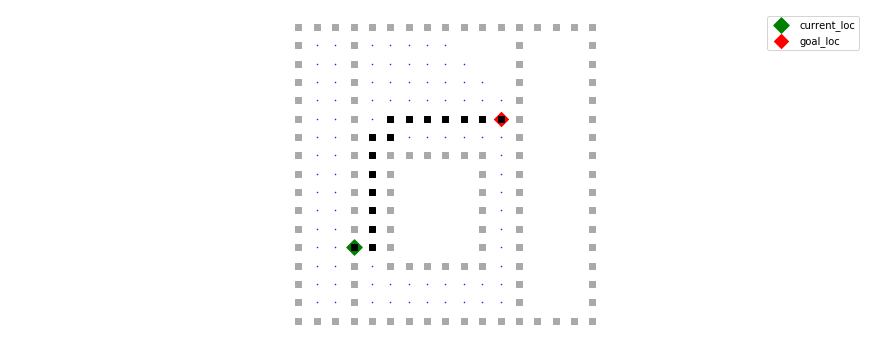

                               Search search: 8.9 path cost, 103 states reached
(2.269, 2.514)
[(2.261, 2.501), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.402, 2.654)


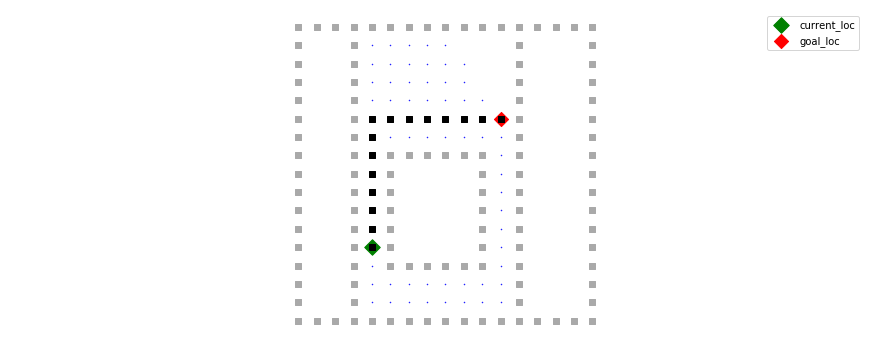

                               Search search: 8.5 path cost, 70 states reached
(2.424, 2.602)
[(2.402, 2.654), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (2.7, 6.9), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.443, 2.438)


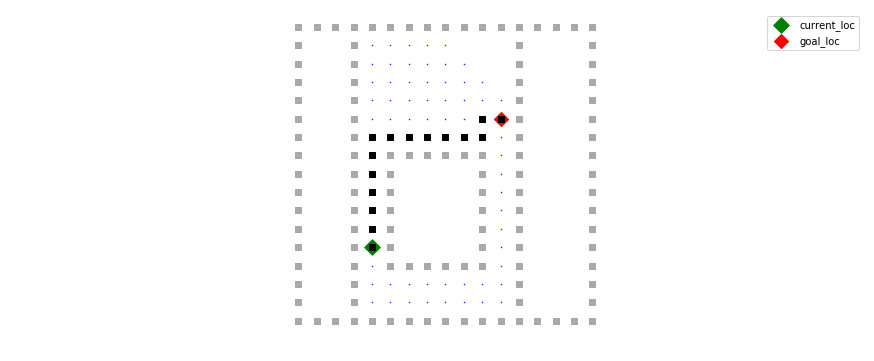

                               Search search: 8.7 path cost, 72 states reached
(2.442, 2.434)
[(2.443, 2.438), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.771, 2.57)


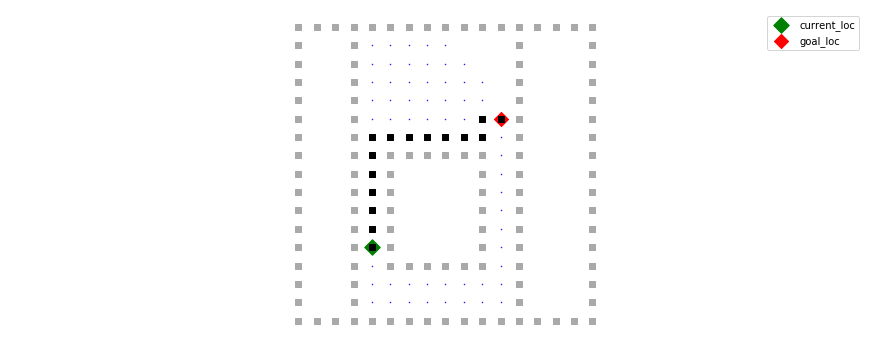

                               Search search: 8.5 path cost, 71 states reached
(2.919, 2.517)
[(2.771, 2.57), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.85, 2.504)


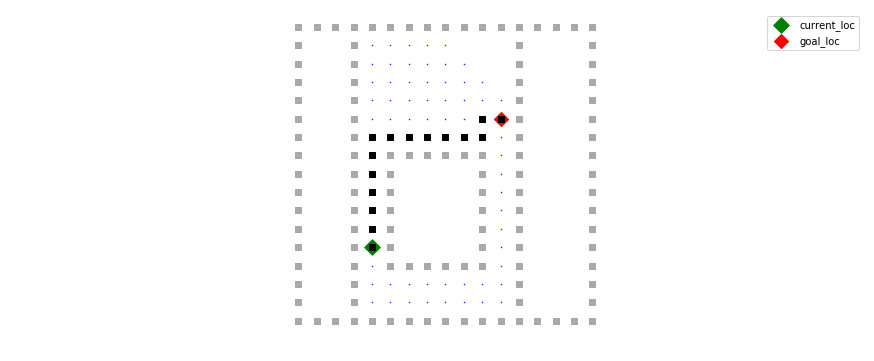

                               Search search: 8.6 path cost, 72 states reached
(2.859, 2.521)
[(2.85, 2.504), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.968, 2.33)


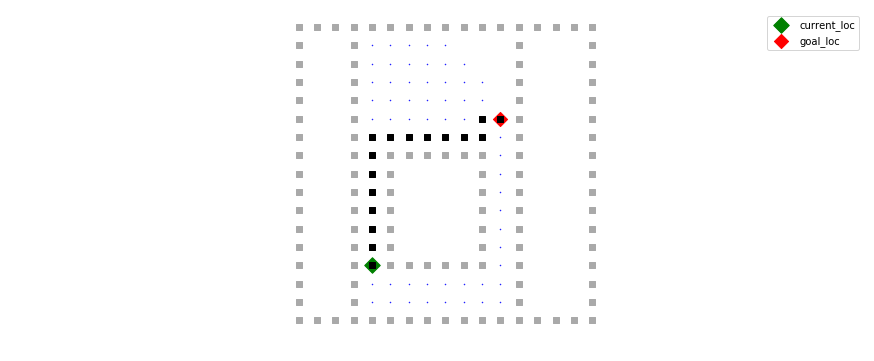

                               Search search: 8.9 path cost, 71 states reached
(3.013, 2.435)
[(2.968, 2.33), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.003, 2.568)


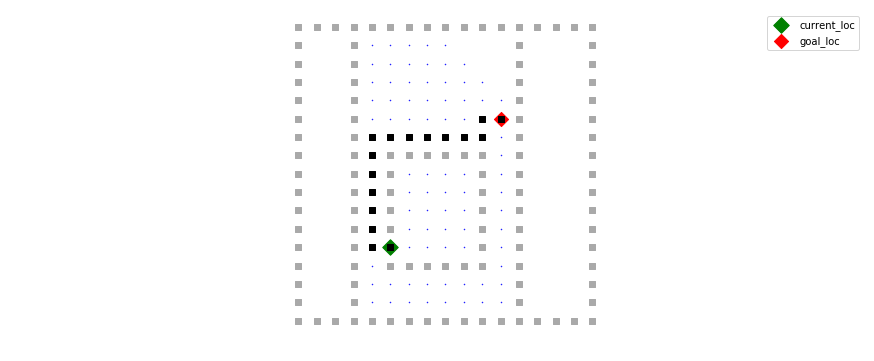

                               Search search: 8.7 path cost, 93 states reached
(3.019, 2.549)
[(3.003, 2.568), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.172, 2.731)


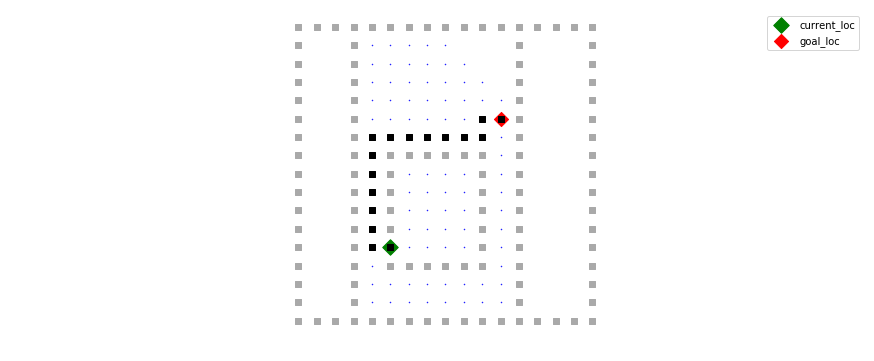

                               Search search: 8.9 path cost, 93 states reached
(3.181, 2.733)
[(3.172, 2.731), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.223, 2.877)


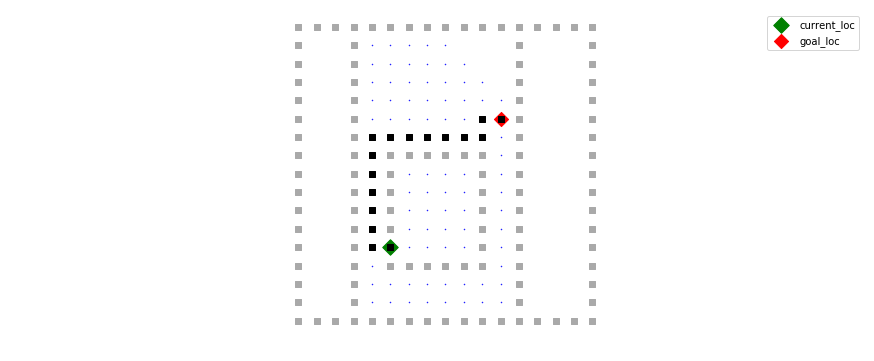

                               Search search: 9.0 path cost, 93 states reached
(3.232, 2.937)
[(3.223, 2.877), (2.7, 2.7), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.06, 3.07)


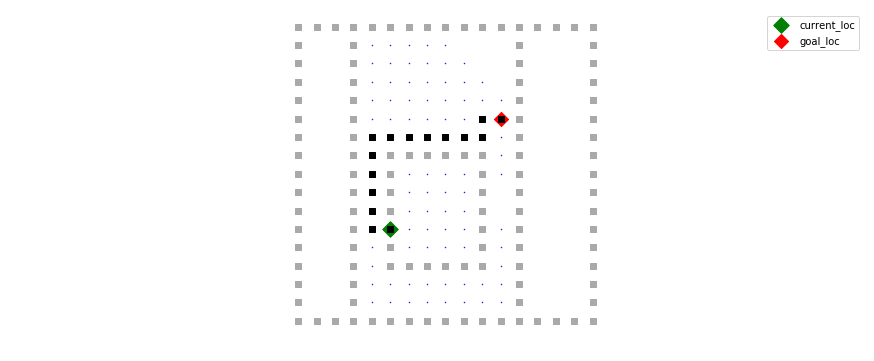

                               Search search: 8.2 path cost, 91 states reached
(3.151, 3.173)
[(3.06, 3.07), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.046, 3.111)


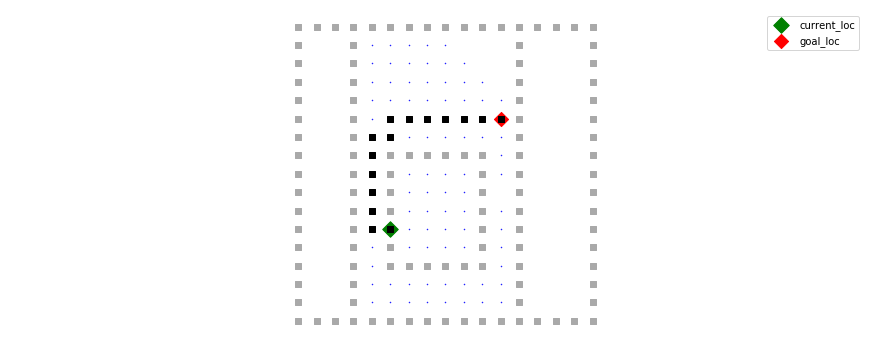

                               Search search: 8.2 path cost, 92 states reached
(3.126, 3.187)
[(3.046, 3.111), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.827, 3.037)


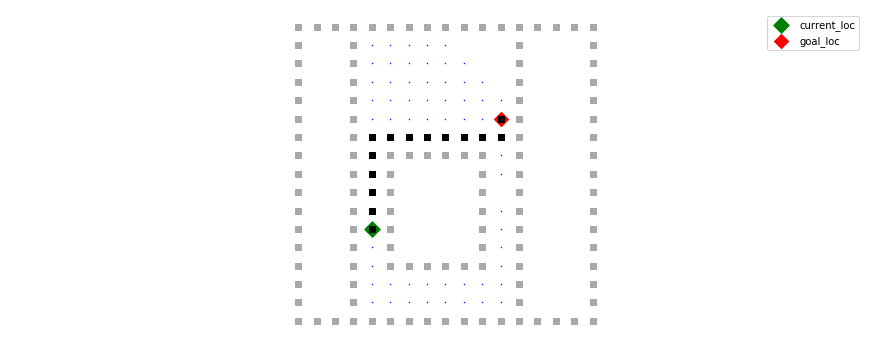

                               Search search: 8.1 path cost, 71 states reached
(2.923, 3.088)
[(2.827, 3.037), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.915, 2.924)


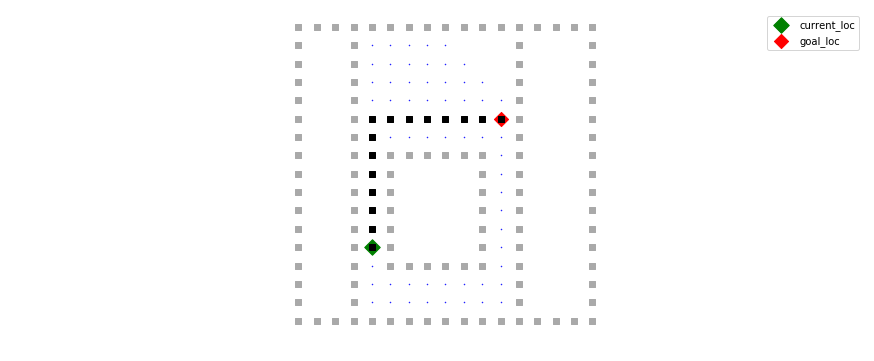

                               Search search: 8.2 path cost, 72 states reached
(2.91, 2.888)
[(2.915, 2.924), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (2.7, 6.9), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.971, 2.928)


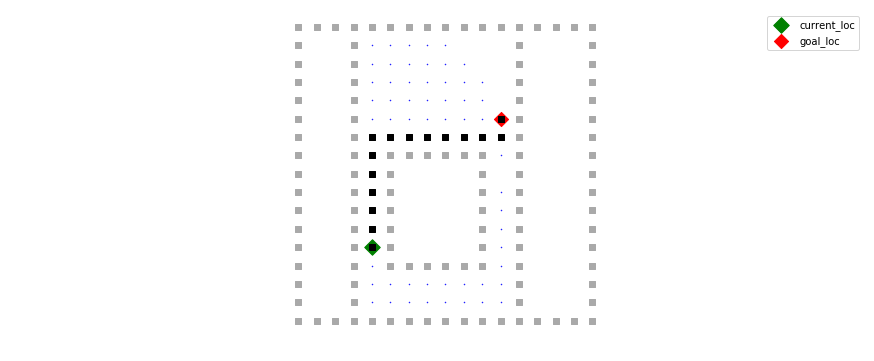

                               Search search: 8.3 path cost, 70 states reached
(2.904, 2.941)
[(2.971, 2.928), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.821, 2.975)


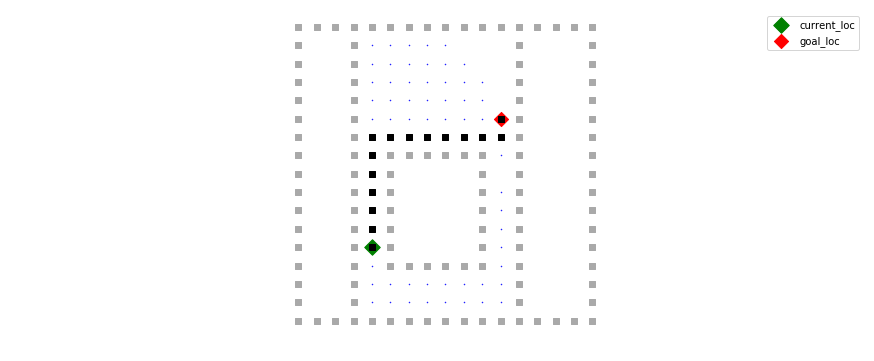

                               Search search: 8.1 path cost, 70 states reached
(2.78, 2.976)
[(2.821, 2.975), (2.7, 3.3), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.741, 3.019)


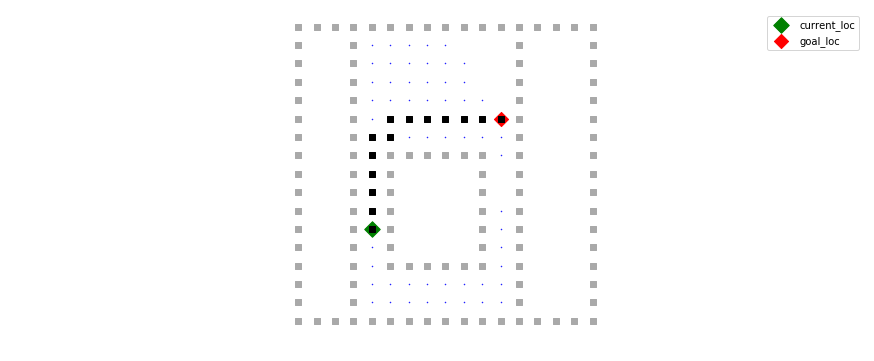

                               Search search: 8.1 path cost, 68 states reached
(2.709, 3.008)
[(2.741, 3.019), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.634, 3.023)


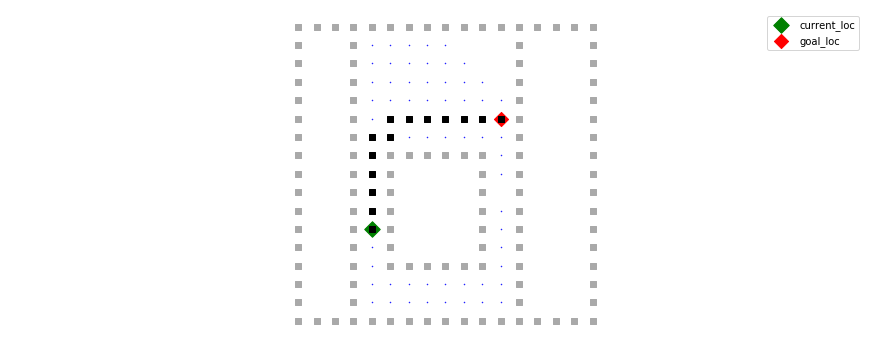

                               Search search: 8.1 path cost, 71 states reached
(2.672, 3.067)
[(2.634, 3.023), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.724, 3.231)


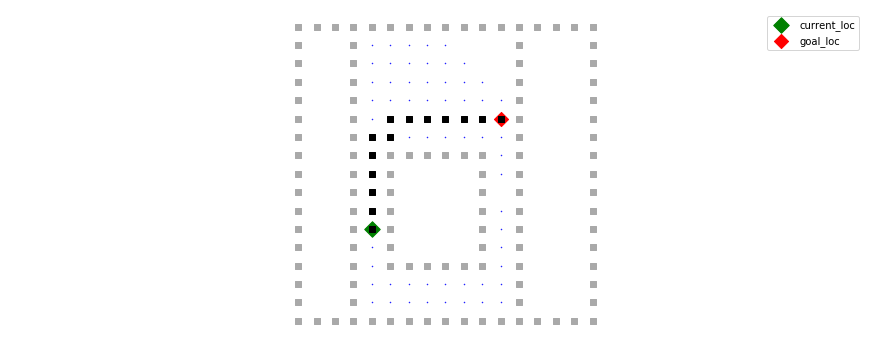

                               Search search: 7.9 path cost, 71 states reached
(2.712, 3.282)
[(2.724, 3.231), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.781, 3.378)


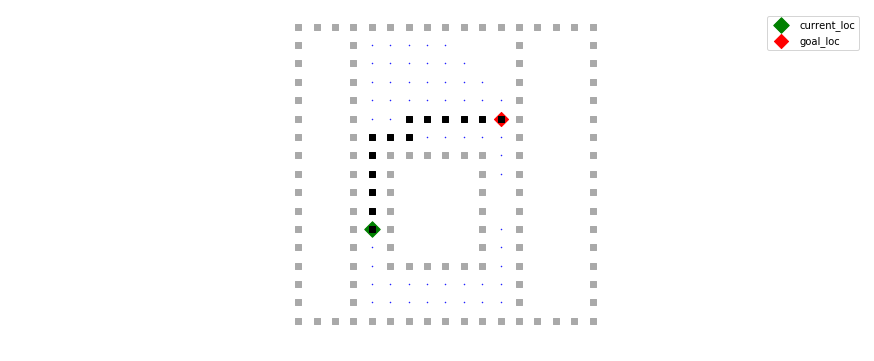

                               Search search: 7.7 path cost, 70 states reached
(2.787, 3.38)
[(2.781, 3.378), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.74, 3.462)


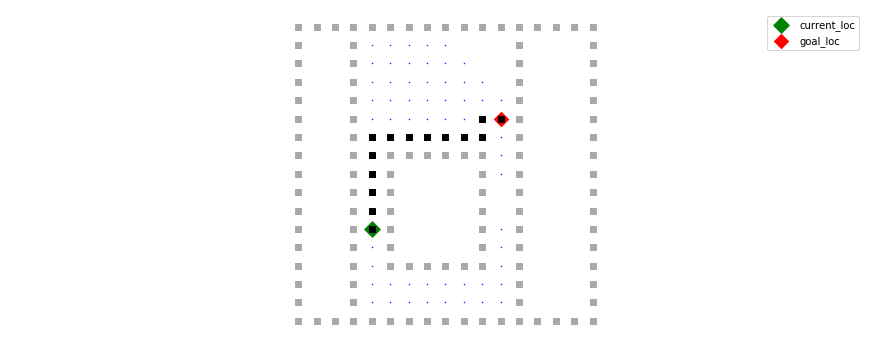

                               Search search: 7.6 path cost, 70 states reached
(2.732, 3.478)
[(2.74, 3.462), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.718, 3.505)


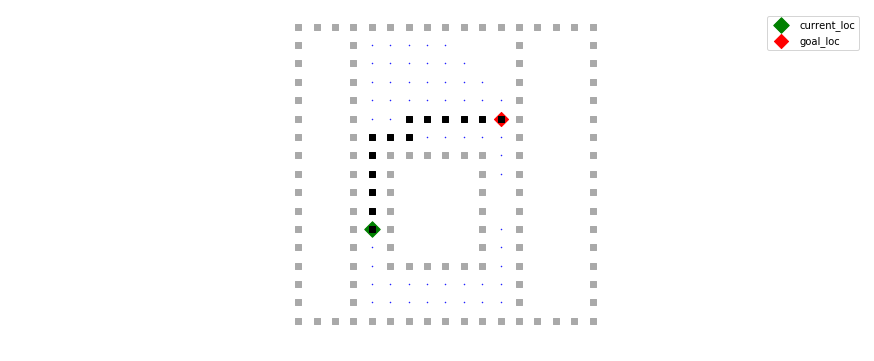

                               Search search: 7.6 path cost, 70 states reached
(2.712, 3.514)
[(2.718, 3.505), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.668, 3.545)


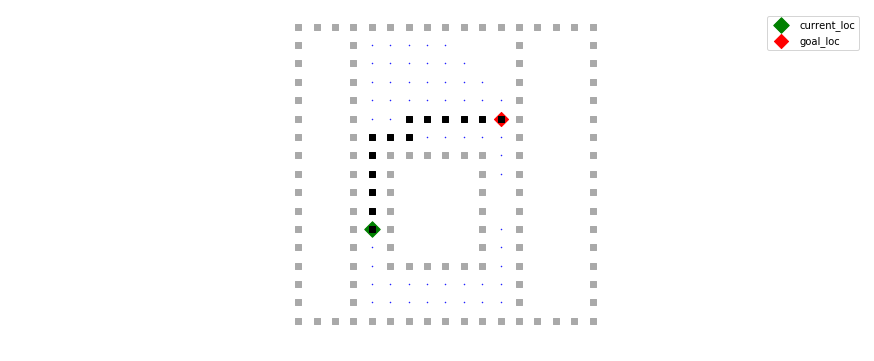

                               Search search: 7.6 path cost, 70 states reached
(2.652, 3.555)
[(2.668, 3.545), (2.7, 3.9), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.635, 3.728)


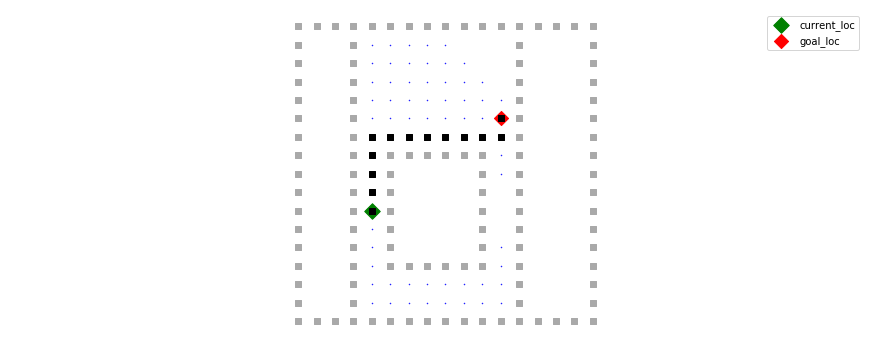

                               Search search: 7.4 path cost, 69 states reached
(2.689, 3.918)
[(2.635, 3.728), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.851, 3.864)


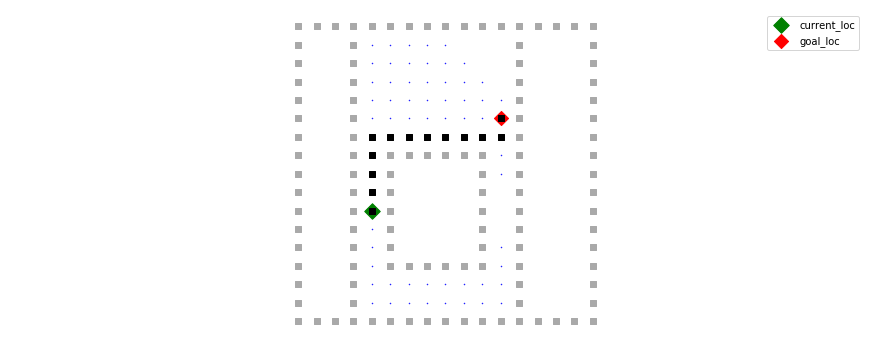

                               Search search: 7.3 path cost, 69 states reached
(2.856, 3.812)
[(2.851, 3.864), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.772, 3.807)


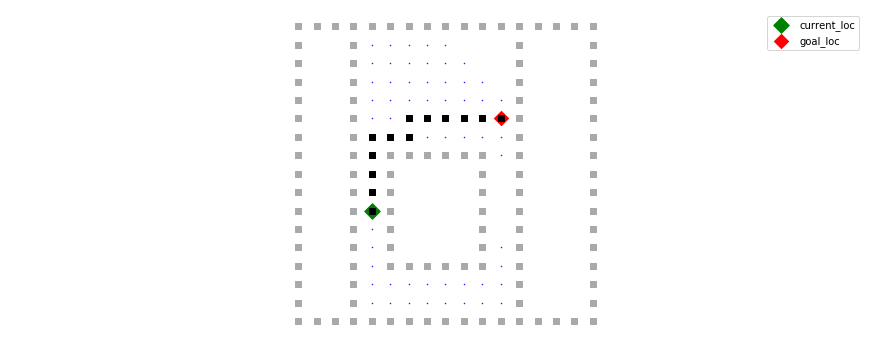

                               Search search: 7.3 path cost, 68 states reached
(2.781, 3.808)
[(2.772, 3.807), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.48, 3.979)


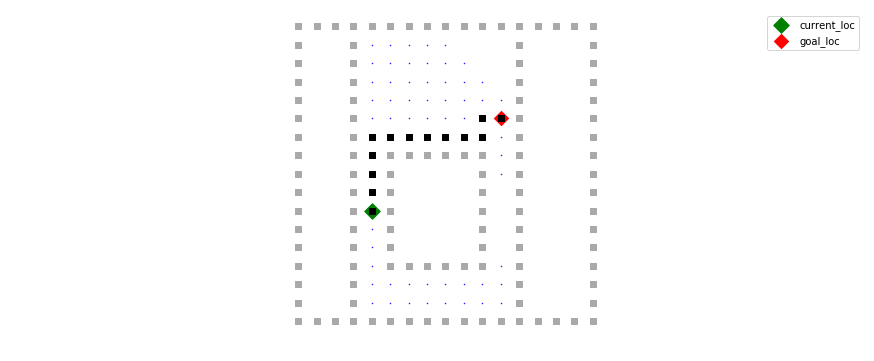

                               Search search: 7.2 path cost, 68 states reached
(2.374, 3.935)
[(2.48, 3.979), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.441, 4.303)


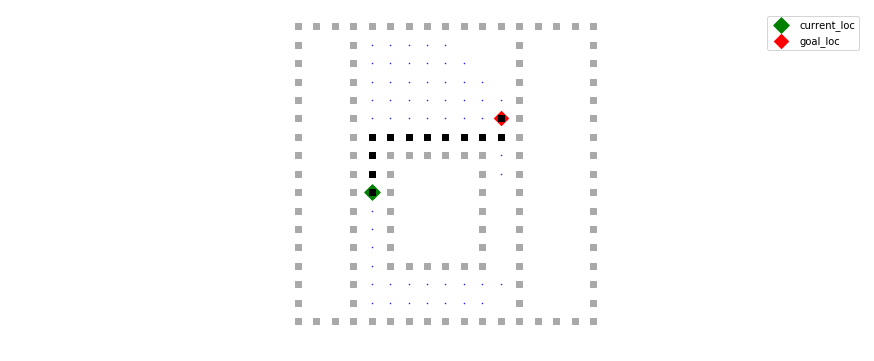

                               Search search: 6.8 path cost, 66 states reached
(2.502, 4.366)
[(2.441, 4.303), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.631, 4.161)


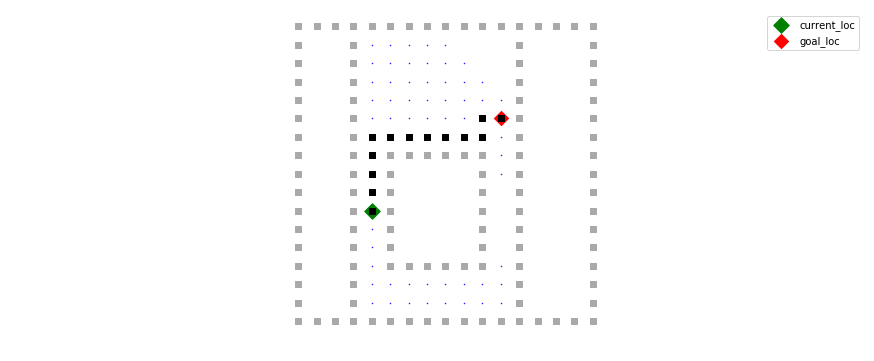

                               Search search: 6.9 path cost, 68 states reached
(2.819, 4.163)
[(2.631, 4.161), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.753, 4.282)


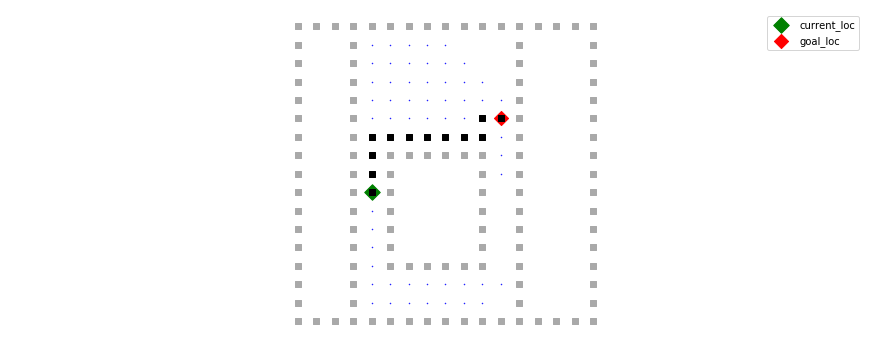

                               Search search: 6.8 path cost, 66 states reached
(2.753, 4.282)
[(2.753, 4.282), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.916, 3.904)


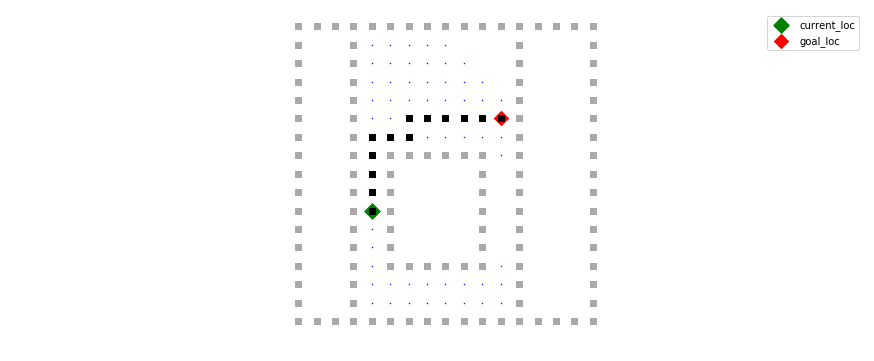

                               Search search: 7.2 path cost, 67 states reached
(2.958, 3.916)
[(2.916, 3.904), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.167, 4.286)


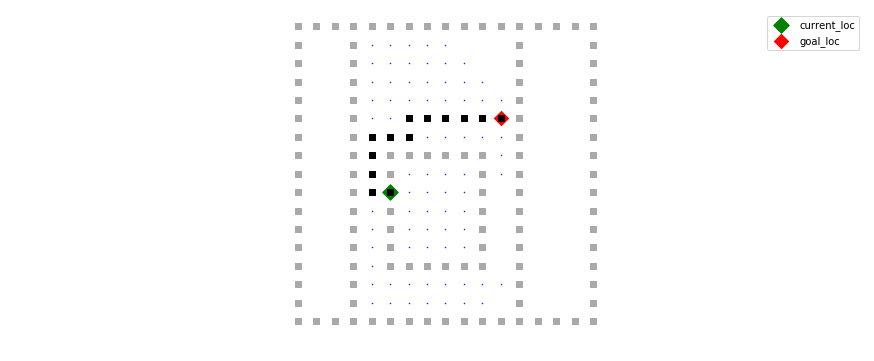

                               Search search: 7.1 path cost, 87 states reached
(3.143, 4.347)
[(3.167, 4.286), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.12, 4.409)


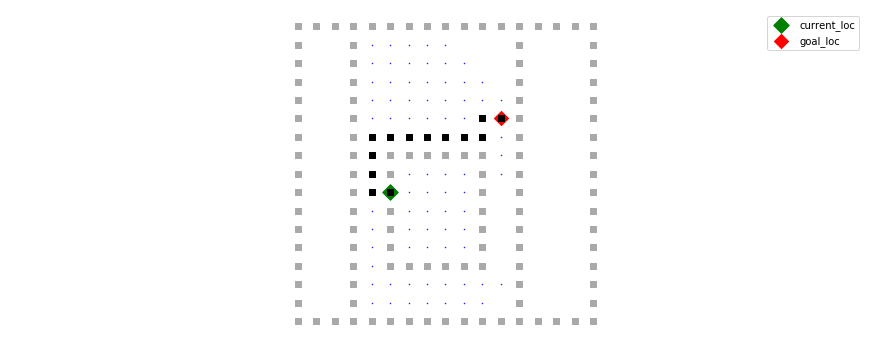

                               Search search: 7.0 path cost, 87 states reached
(3.08, 4.369)
[(3.12, 4.409), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.992, 4.435)


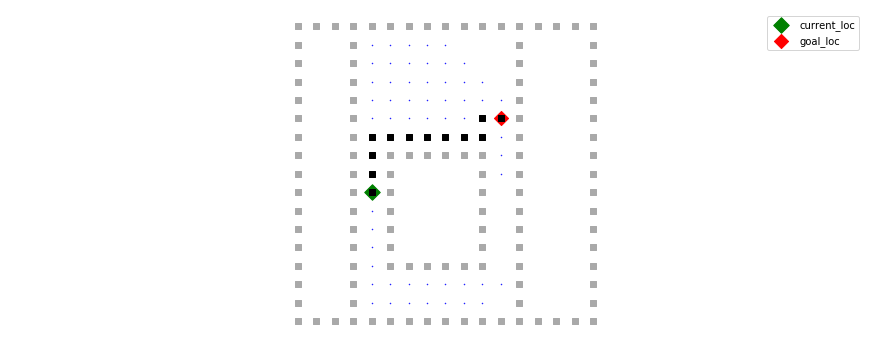

                               Search search: 6.7 path cost, 66 states reached
(2.997, 4.444)
[(2.992, 4.435), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.969, 4.44)


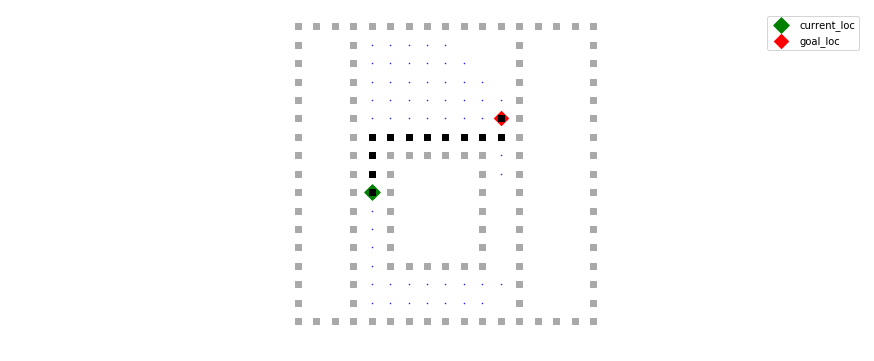

                               Search search: 6.7 path cost, 66 states reached
(2.945, 4.3)
[(2.969, 4.44), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.911, 4.498)


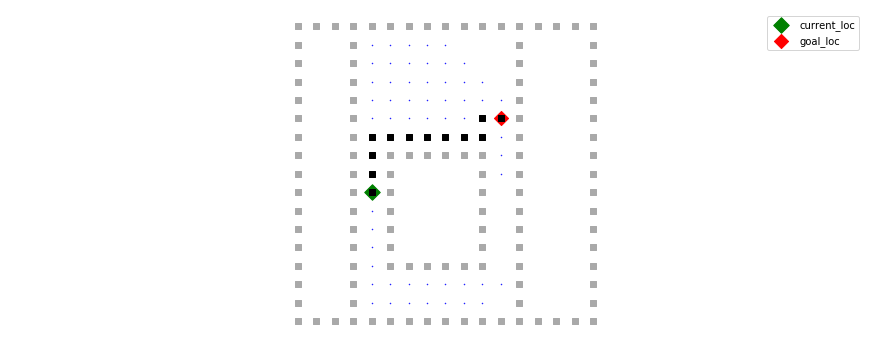

                               Search search: 6.6 path cost, 66 states reached
(2.957, 4.548)
[(2.911, 4.498), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.06, 4.601)


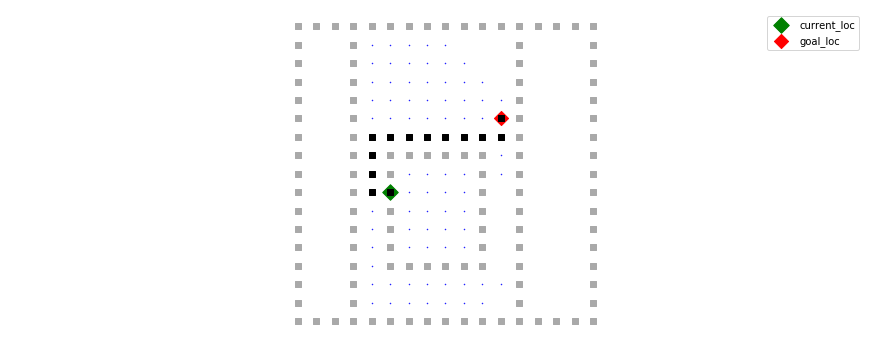

                               Search search: 7.0 path cost, 87 states reached
(3.12, 4.614)
[(3.06, 4.601), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.027, 4.767)


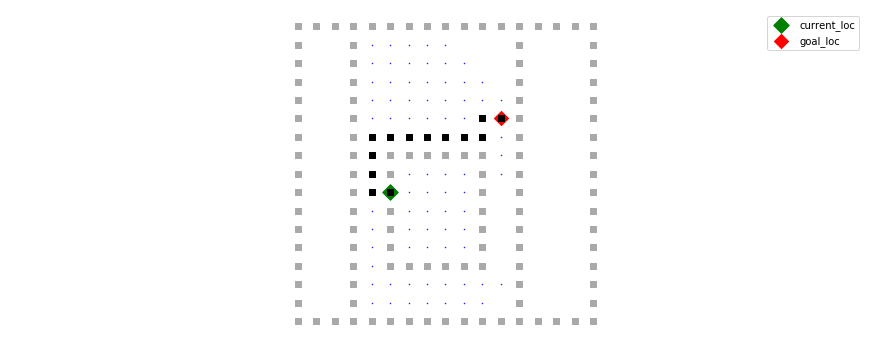

                               Search search: 7.0 path cost, 87 states reached
(2.98, 4.742)
[(3.027, 4.767), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.664, 5.024)


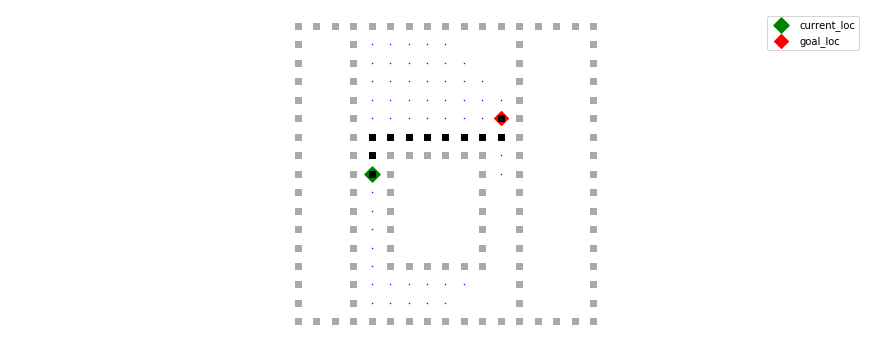

                               Search search: 6.1 path cost, 62 states reached
(2.622, 5.053)
[(2.664, 5.024), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.882, 5.195)


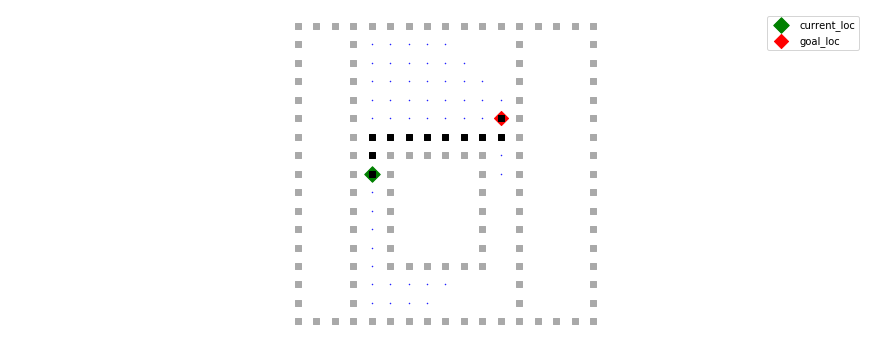

                               Search search: 5.9 path cost, 60 states reached
(3.046, 5.296)
[(2.882, 5.195), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.837, 5.111)


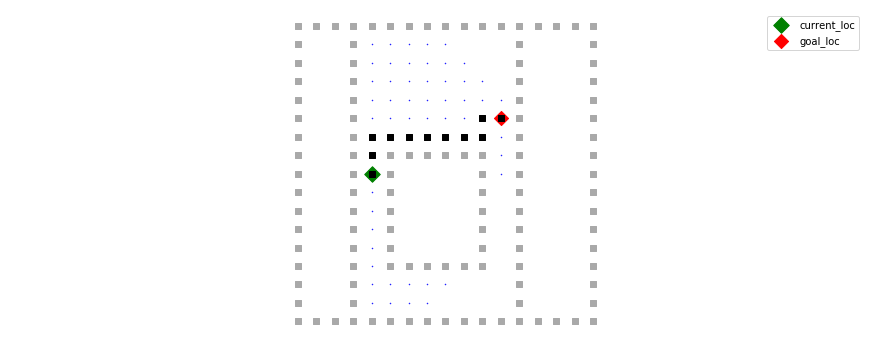

                               Search search: 6.0 path cost, 60 states reached
(2.804, 5.268)
[(2.837, 5.111), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.558, 5.137)


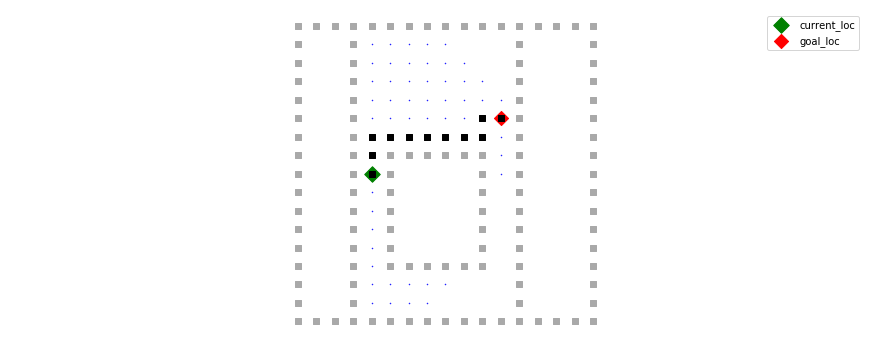

                               Search search: 6.0 path cost, 60 states reached
(2.631, 5.077)
[(2.558, 5.137), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.494, 5.219)


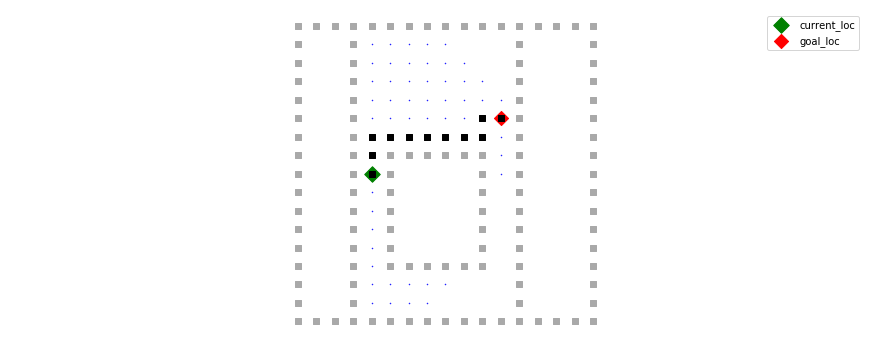

                               Search search: 5.9 path cost, 60 states reached
(2.549, 5.073)
[(2.494, 5.219), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.734, 4.984)


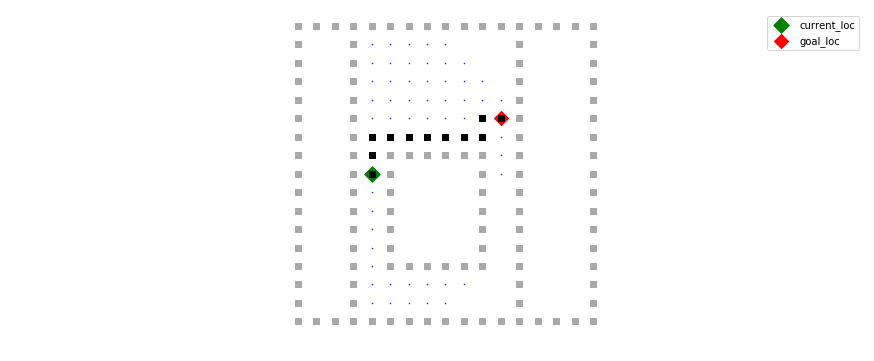

                               Search search: 6.1 path cost, 62 states reached
(2.652, 5.116)
[(2.734, 4.984), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.024, 5.092)


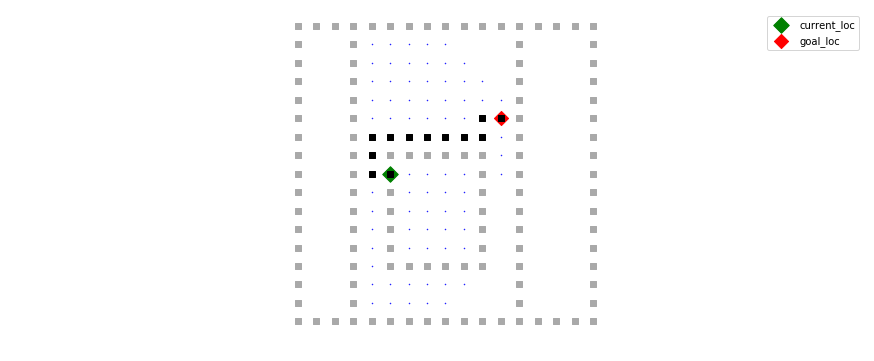

                               Search search: 6.3 path cost, 83 states reached
(2.87, 5.109)
[(3.024, 5.092), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.506, 5.092)


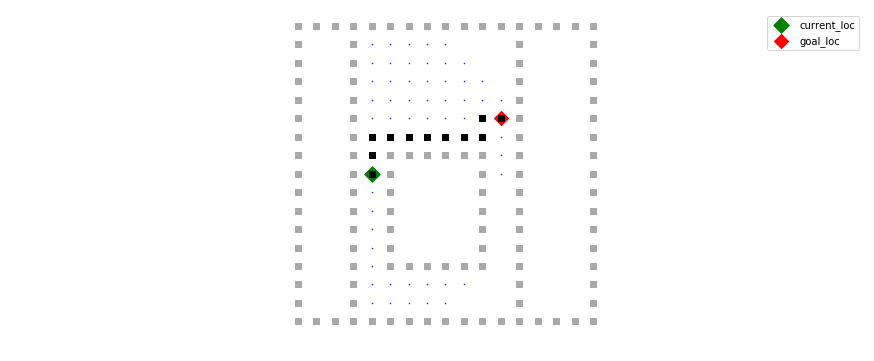

                               Search search: 6.0 path cost, 62 states reached
(2.441, 4.928)
[(2.506, 5.092), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.345, 4.781)


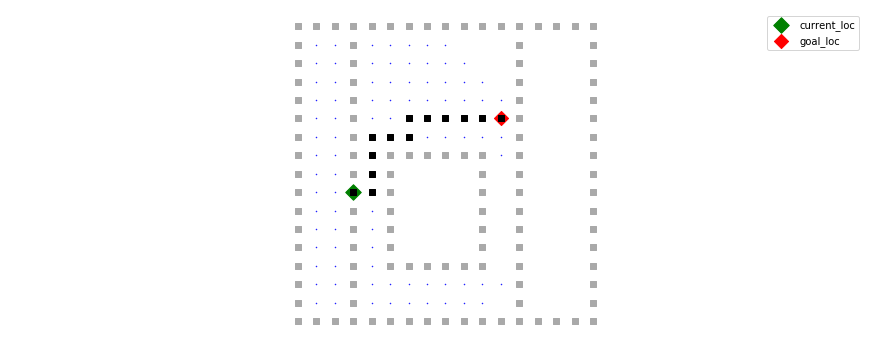

                               Search search: 7.1 path cost, 96 states reached
(2.53, 4.898)
[(2.345, 4.781), (2.7, 4.5), (2.7, 5.1), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.747, 5.194)


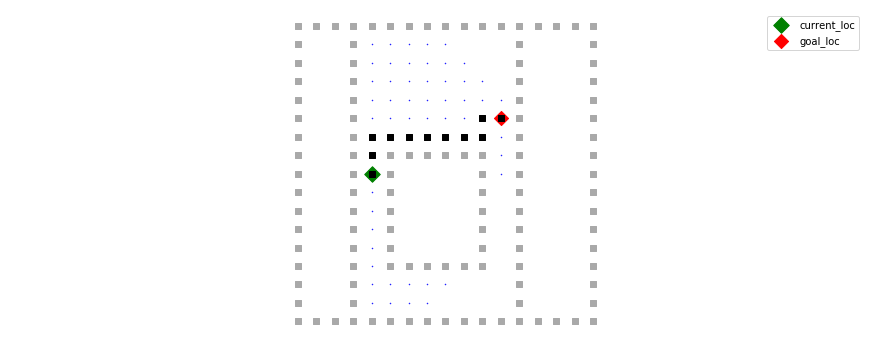

                               Search search: 5.9 path cost, 60 states reached
(2.567, 5.376)
[(2.747, 5.194), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.003, 5.538)


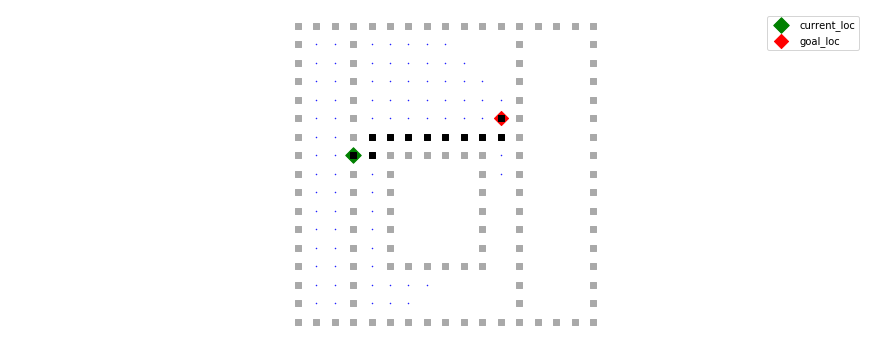

                               Search search: 6.1 path cost, 89 states reached
(1.97, 5.467)
[(2.003, 5.538), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.286, 6.094)


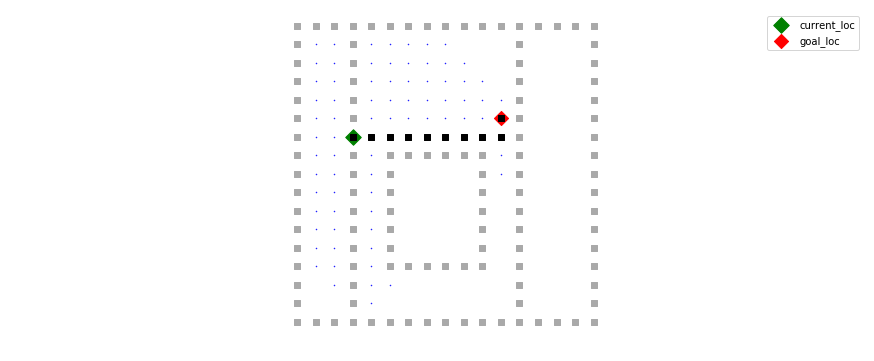

                               Search search: 5.3 path cost, 82 states reached
(2.178, 5.94)
[(2.286, 6.094), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (1.777, 5.642)


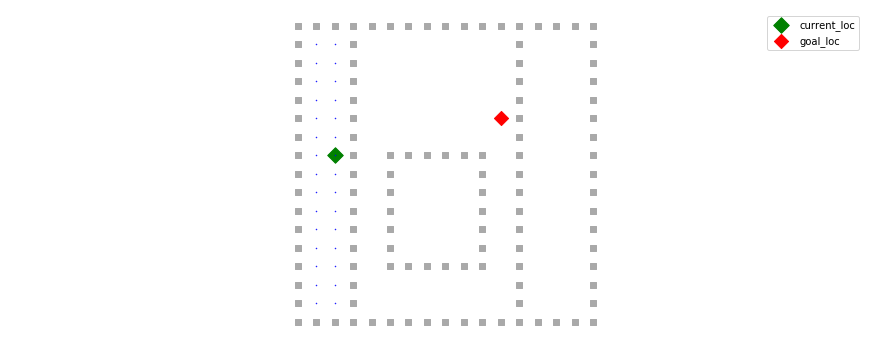

                               Search search: inf path cost, 30 states reached
(1.54, 5.743)
[]
Initial_point: (2.565, 5.91)


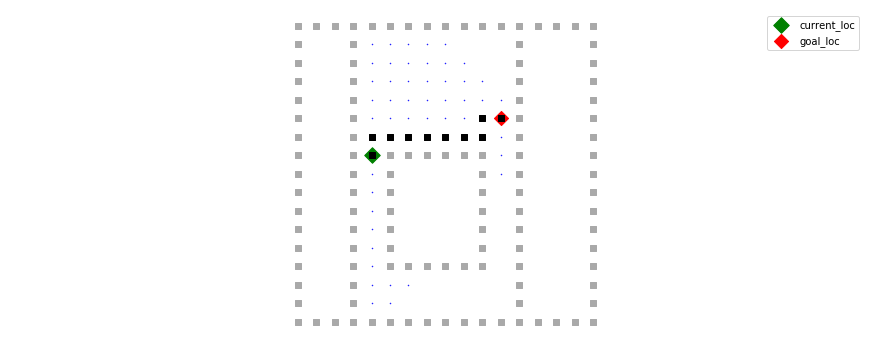

                               Search search: 5.2 path cost, 56 states reached
(2.602, 5.936)
[(2.565, 5.91), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.648, 5.936)


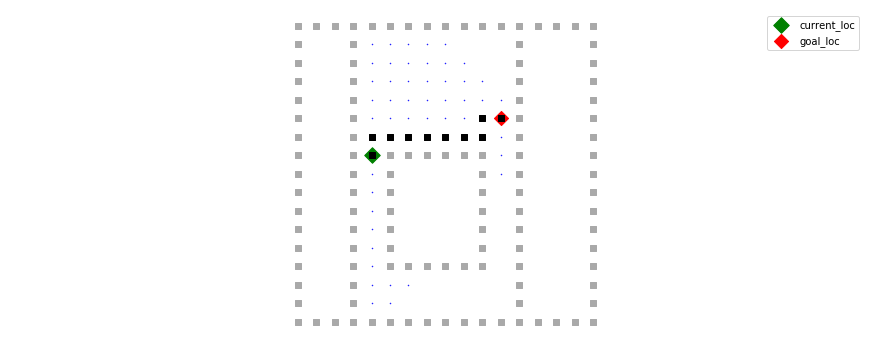

                               Search search: 5.2 path cost, 56 states reached
(2.616, 5.921)
[(2.648, 5.936), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.574, 5.674)


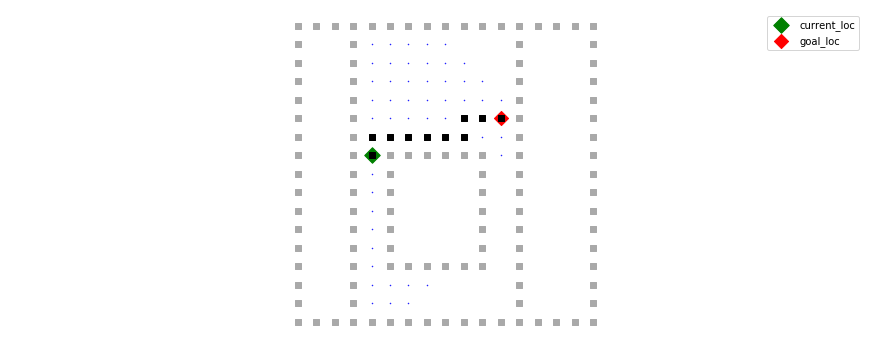

                               Search search: 5.4 path cost, 57 states reached
(2.333, 5.821)
[(2.574, 5.674), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.571, 5.986)


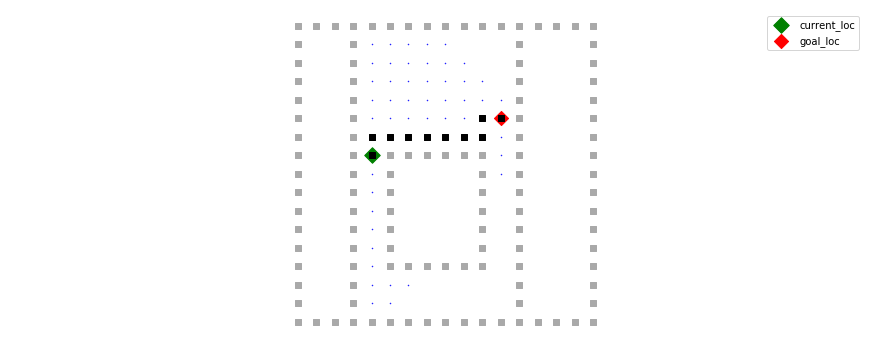

                               Search search: 5.1 path cost, 56 states reached
(2.662, 6.023)
[(2.571, 5.986), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (1.912, 5.621)


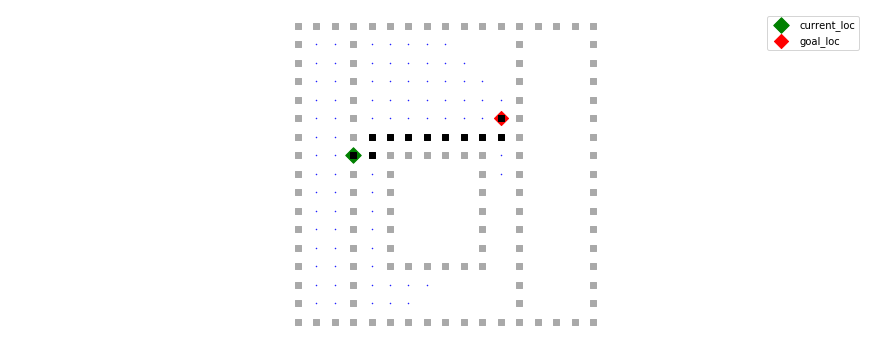

                               Search search: 6.2 path cost, 89 states reached
(2.328, 6.026)
[(1.912, 5.621), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.323, 5.742)


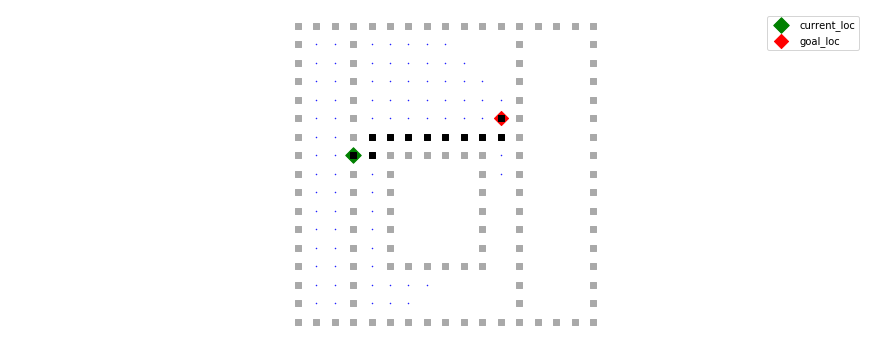

                               Search search: 5.8 path cost, 89 states reached
(2.271, 5.676)
[(2.323, 5.742), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.529, 6.061)


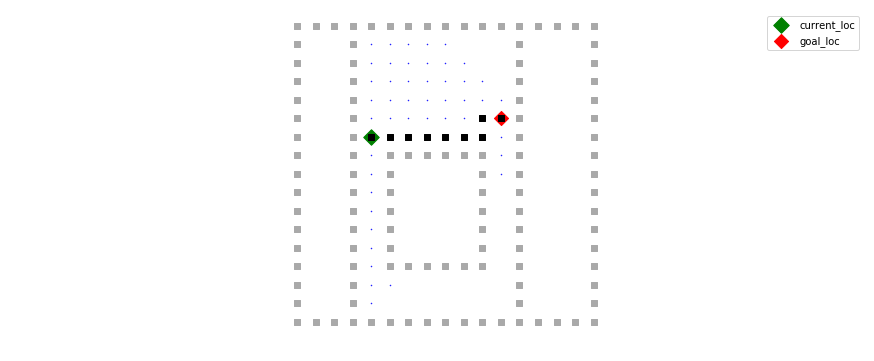

                               Search search: 5.0 path cost, 54 states reached
(2.322, 5.894)
[(2.529, 6.061), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.126, 6.144)


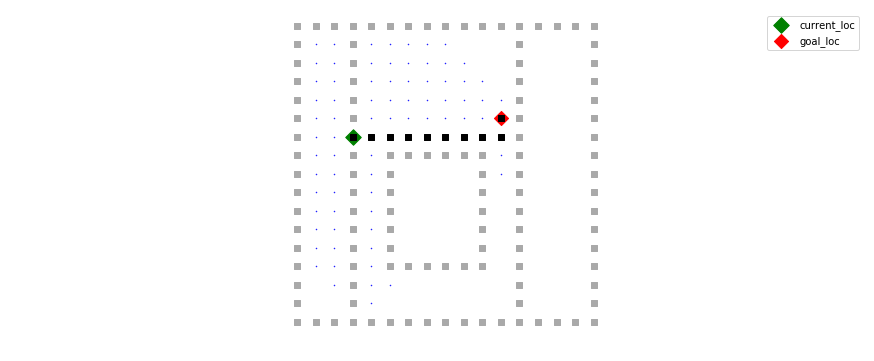

                               Search search: 5.4 path cost, 82 states reached
(2.638, 6.544)
[(2.126, 6.144), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (1.475, 6.197)


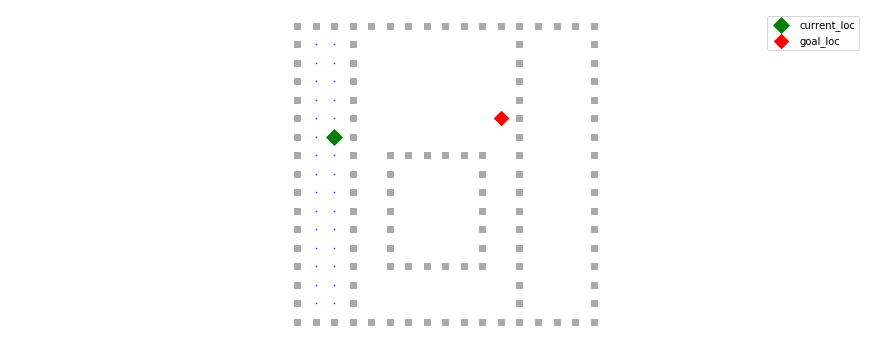

                               Search search: inf path cost, 30 states reached
(1.422, 6.098)
[]
Initial_point: (1.87, 6.071)


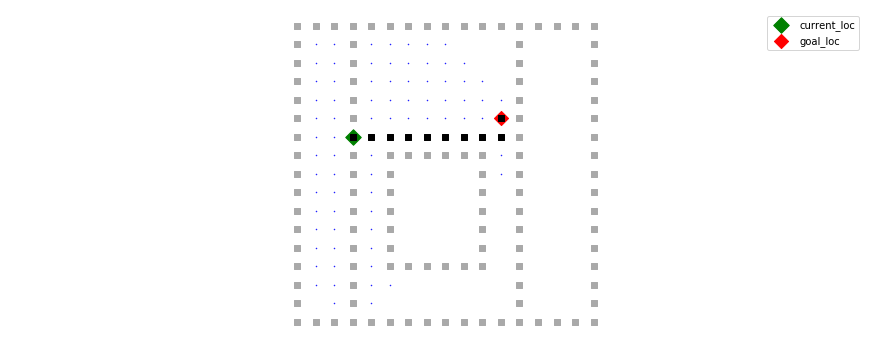

                               Search search: 5.7 path cost, 84 states reached
(1.87, 6.071)
[(1.87, 6.071), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (1.936, 6.209)


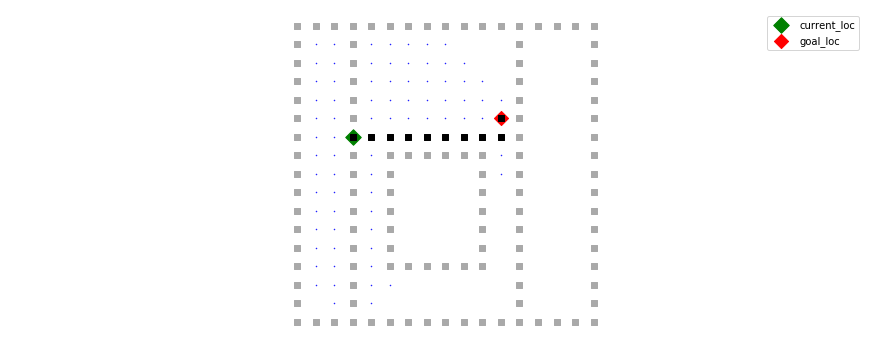

                               Search search: 5.6 path cost, 84 states reached
(1.937, 6.21)
[(1.936, 6.209), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (1.908, 6.219)


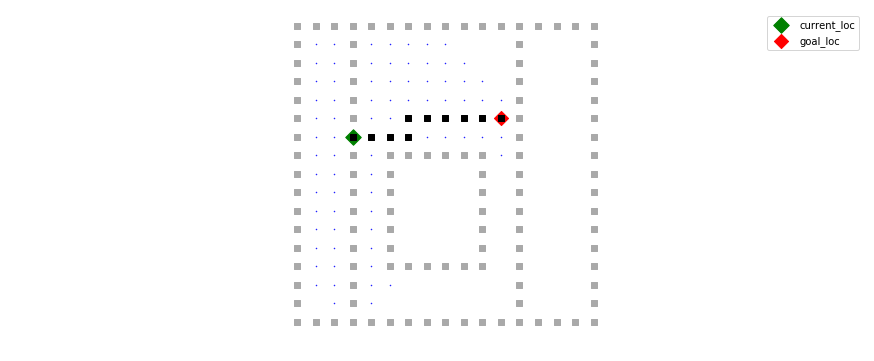

                               Search search: 5.6 path cost, 83 states reached
(1.902, 6.22)
[(1.908, 6.219), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (1.901, 6.212)


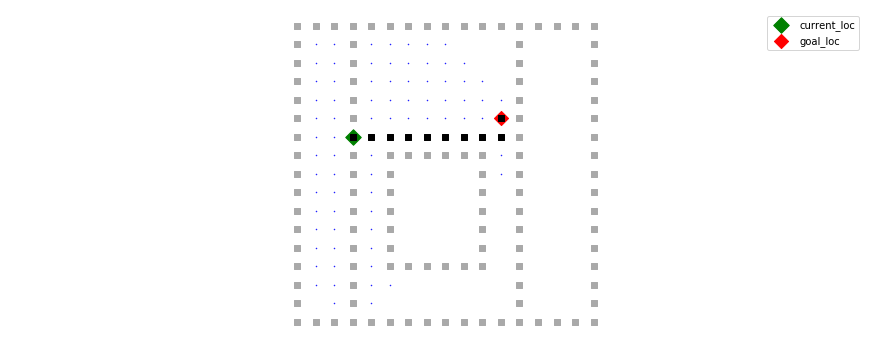

                               Search search: 5.6 path cost, 84 states reached
(1.898, 6.217)
[(1.901, 6.212), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (1.955, 6.103)


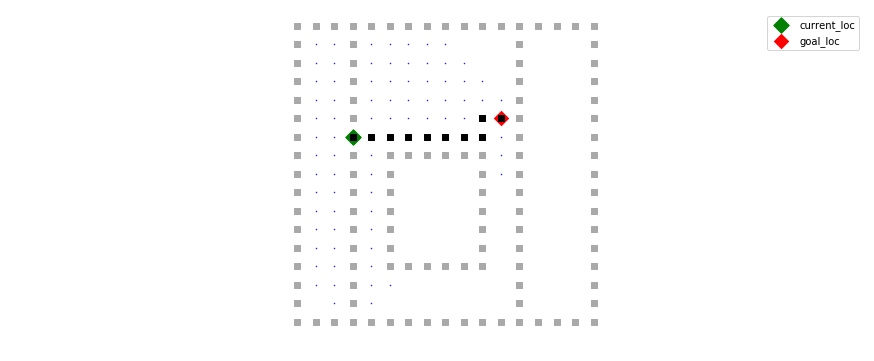

                               Search search: 5.6 path cost, 84 states reached
(1.57, 6.055)
[(1.955, 6.103), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (1.66, 6.046)


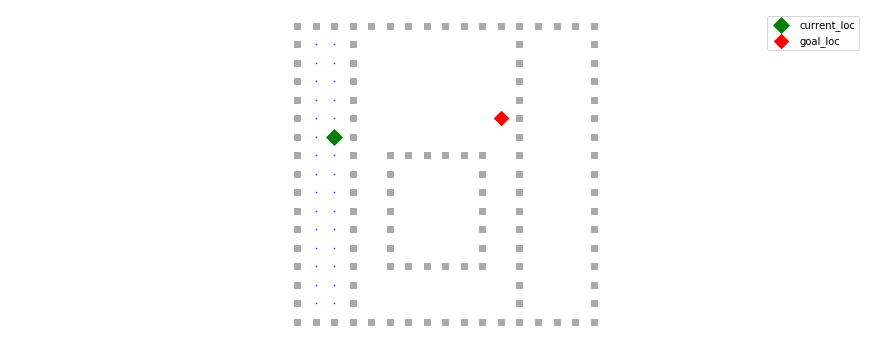

                               Search search: inf path cost, 30 states reached
(1.987, 6.054)
[]
Initial_point: (2.146, 5.808)


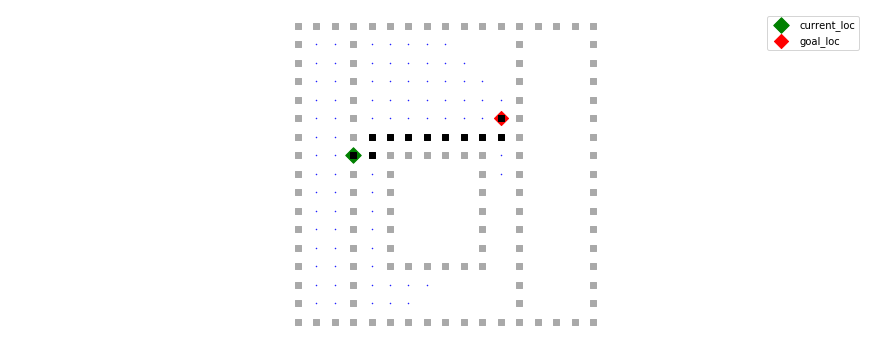

                               Search search: 6.0 path cost, 89 states reached
(2.146, 5.808)
[(2.146, 5.808), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (1.459, 5.977)


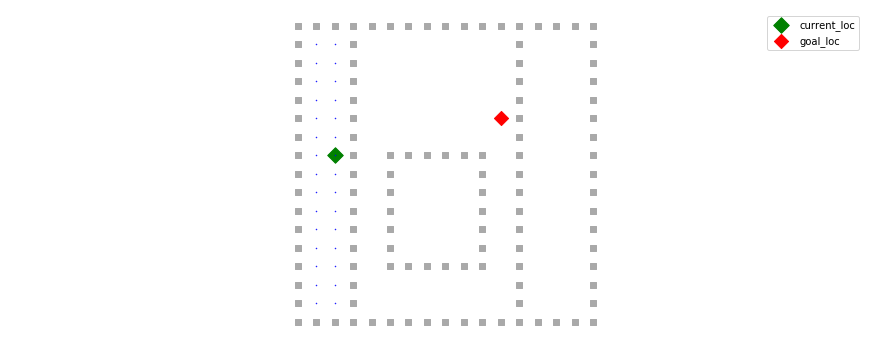

                               Search search: inf path cost, 30 states reached
(1.445, 5.958)
[]
Initial_point: (1.841, 6.093)


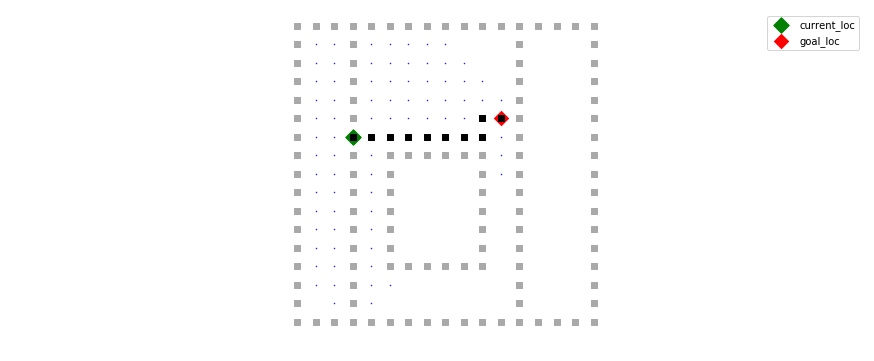

                               Search search: 5.7 path cost, 84 states reached
(1.87, 6.073)
[(1.841, 6.093), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.199, 6.213)


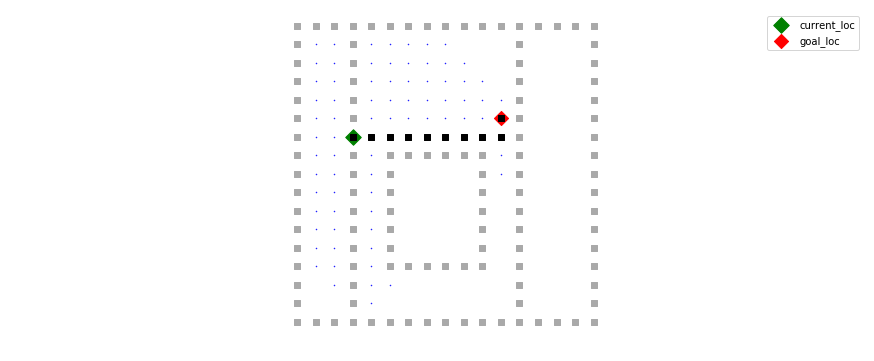

                               Search search: 5.3 path cost, 82 states reached
(2.061, 6.134)
[(2.199, 6.213), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.505, 5.922)


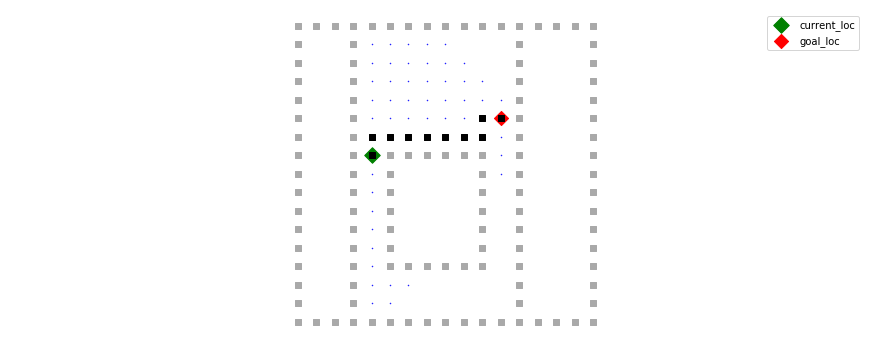

                               Search search: 5.2 path cost, 56 states reached
(2.441, 5.811)
[(2.505, 5.922), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.558, 5.882)


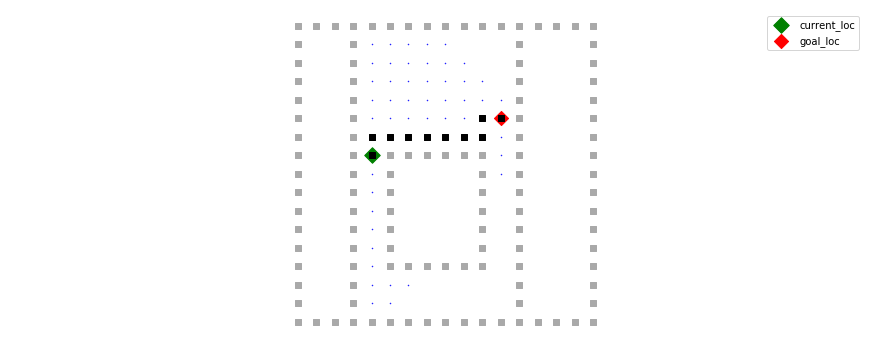

                               Search search: 5.2 path cost, 56 states reached
(2.525, 5.875)
[(2.558, 5.882), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.482, 5.917)


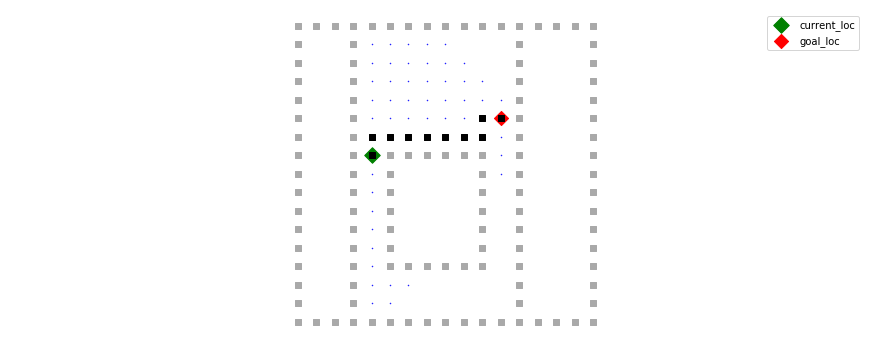

                               Search search: 5.2 path cost, 56 states reached
(2.383, 5.766)
[(2.482, 5.917), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.616, 6.124)


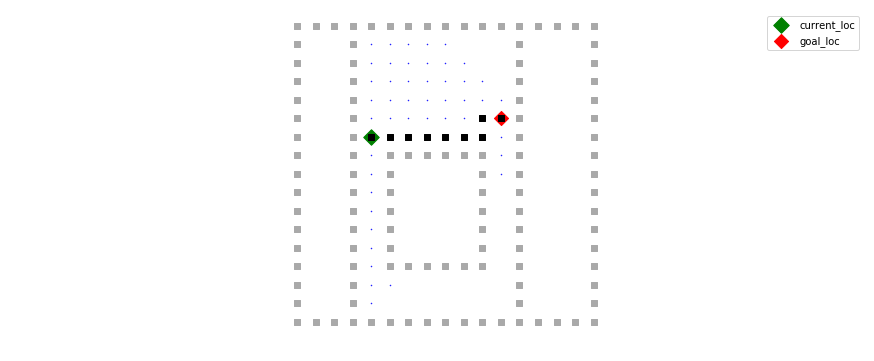

                               Search search: 4.9 path cost, 54 states reached
(2.485, 5.95)
[(2.616, 6.124), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.329, 5.843)


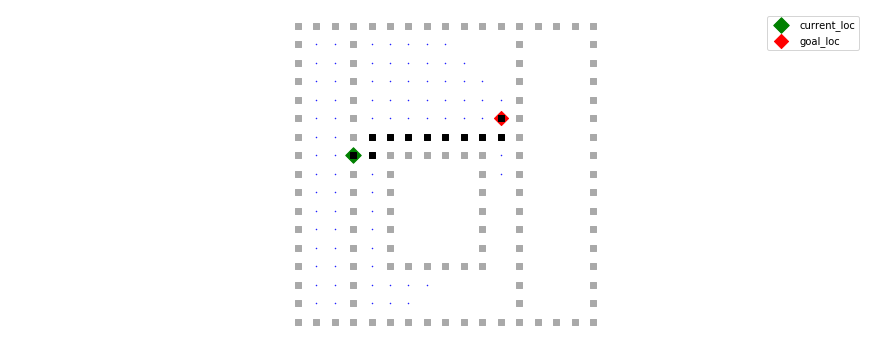

                               Search search: 5.8 path cost, 89 states reached
(2.458, 5.854)
[(2.329, 5.843), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.29, 6.055)


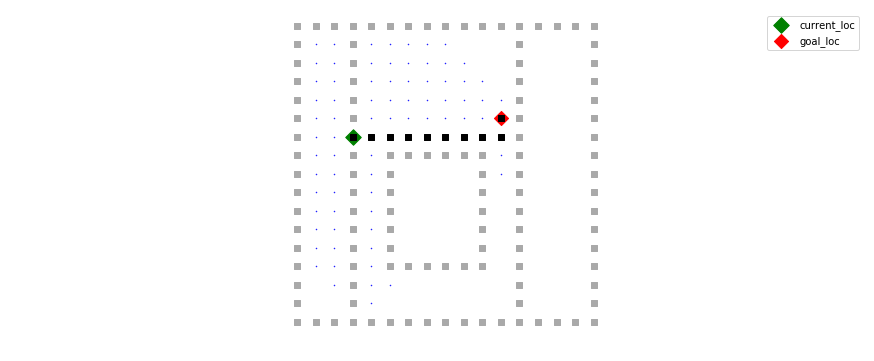

                               Search search: 5.3 path cost, 82 states reached
(2.333, 6.067)
[(2.29, 6.055), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.461, 5.984)


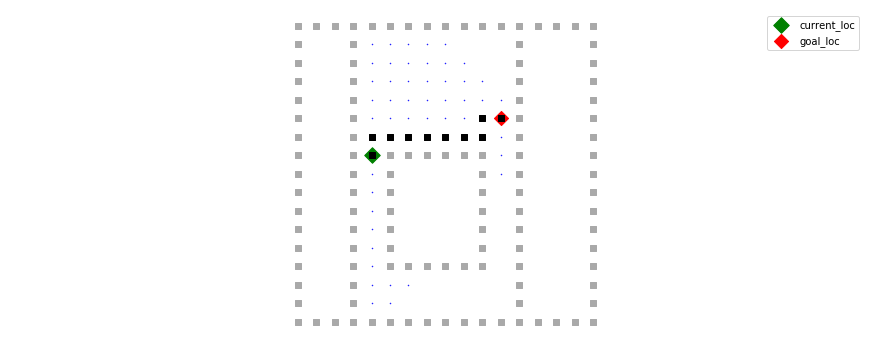

                               Search search: 5.2 path cost, 56 states reached
(2.495, 6.054)
[(2.461, 5.984), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.534, 6.074)


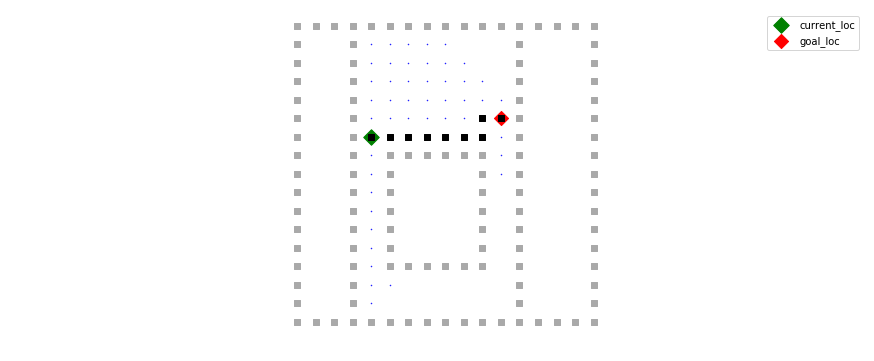

                               Search search: 5.0 path cost, 54 states reached
(2.58, 6.084)
[(2.534, 6.074), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.564, 6.051)


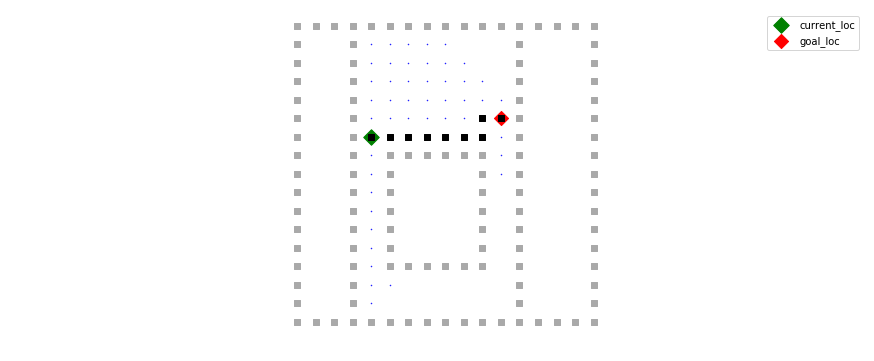

                               Search search: 5.0 path cost, 54 states reached
(2.296, 6.088)
[(2.564, 6.051), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.591, 6.0)


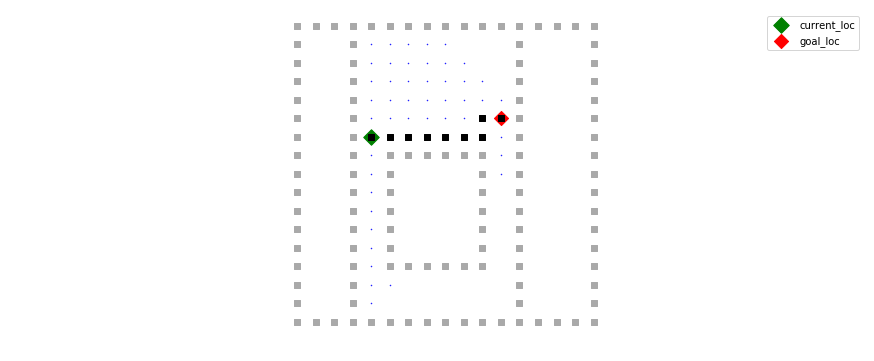

                               Search search: 5.0 path cost, 54 states reached
(2.663, 5.984)
[(2.591, 6.0), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.193, 5.817)


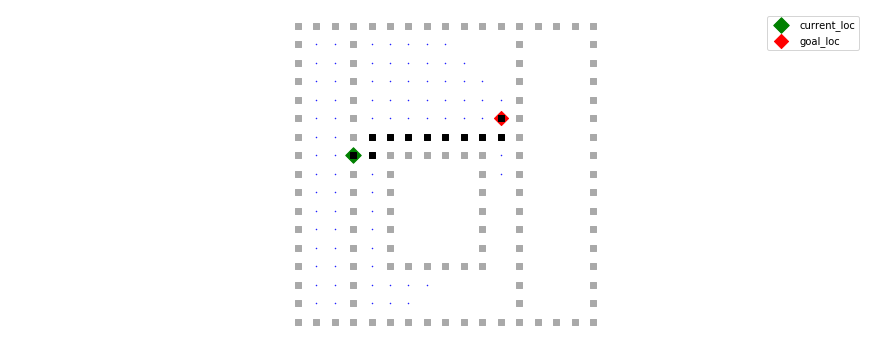

                               Search search: 5.9 path cost, 89 states reached
(2.215, 5.771)
[(2.193, 5.817), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.215, 5.771)


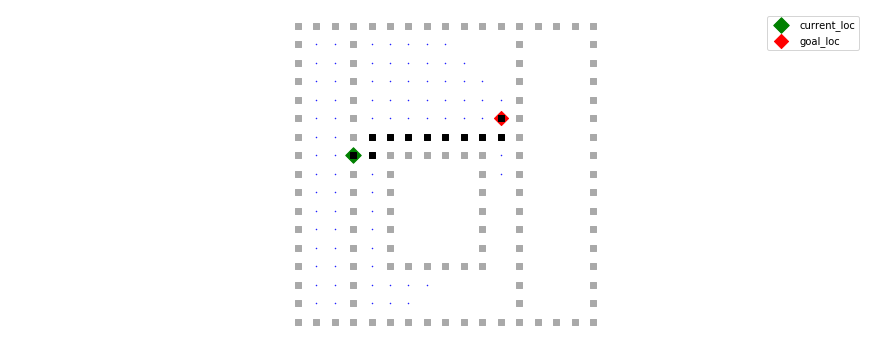

                               Search search: 5.9 path cost, 89 states reached
(2.215, 5.771)
[(2.215, 5.771), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.215, 5.771)


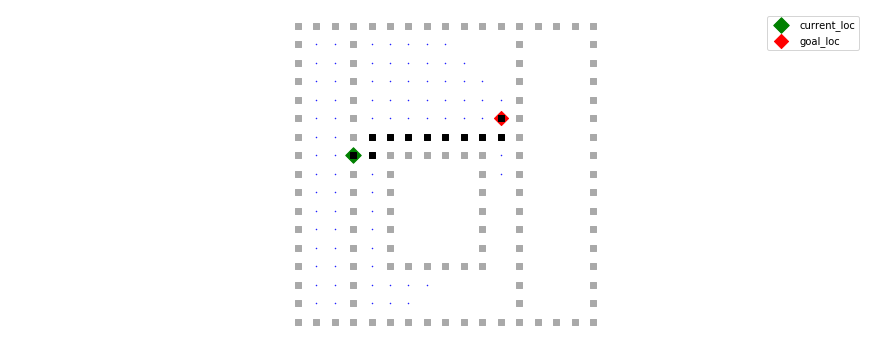

                               Search search: 5.9 path cost, 89 states reached
(2.215, 5.771)
[(2.215, 5.771), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.215, 5.771)


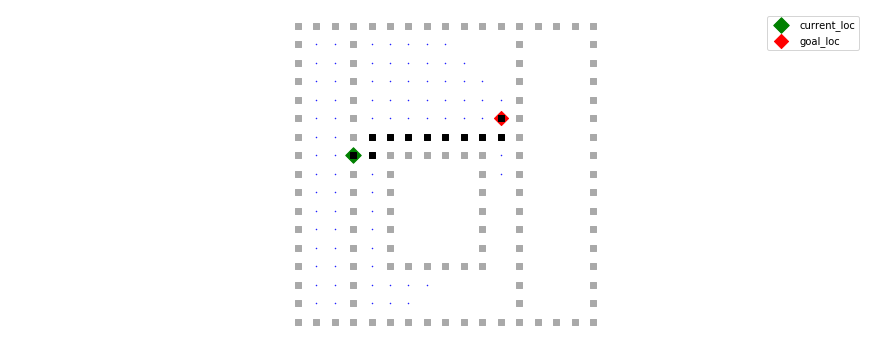

                               Search search: 5.9 path cost, 89 states reached
(2.215, 5.771)
[(2.215, 5.771), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.215, 5.771)


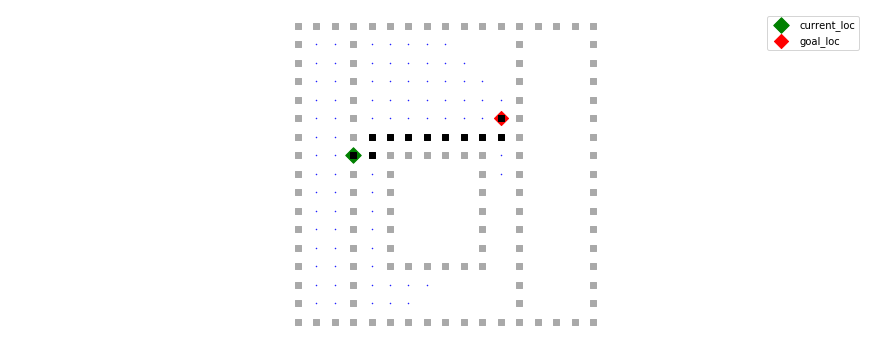

                               Search search: 5.9 path cost, 89 states reached
(2.215, 5.771)
[(2.215, 5.771), (2.7, 5.7), (2.7, 6.3), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (2.942, 6.152)


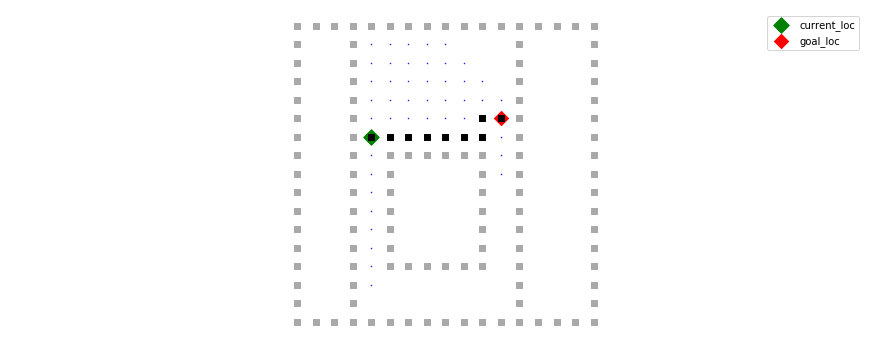

                               Search search: 4.6 path cost, 52 states reached
(2.967, 6.175)
[(2.942, 6.152), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (2.914, 6.319)


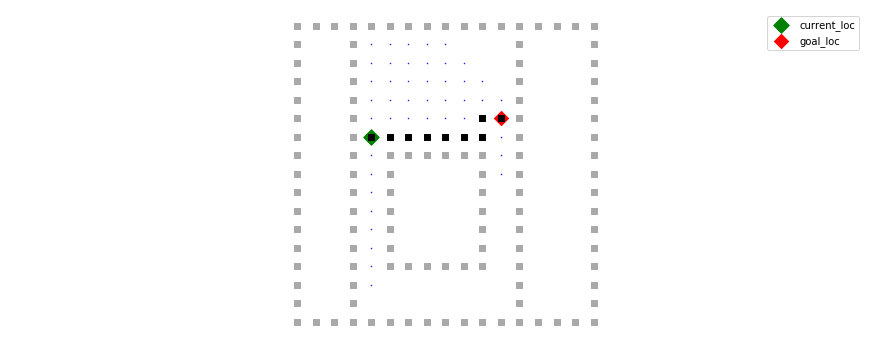

                               Search search: 4.6 path cost, 52 states reached
(2.697, 6.24)
[(2.914, 6.319), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.303, 6.152)


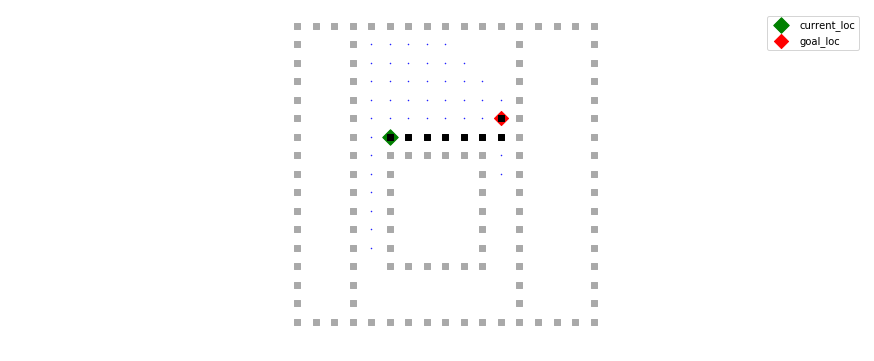

                               Search search: 4.2 path cost, 50 states reached
(3.317, 5.919)
[(3.303, 6.152), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.392, 5.991)


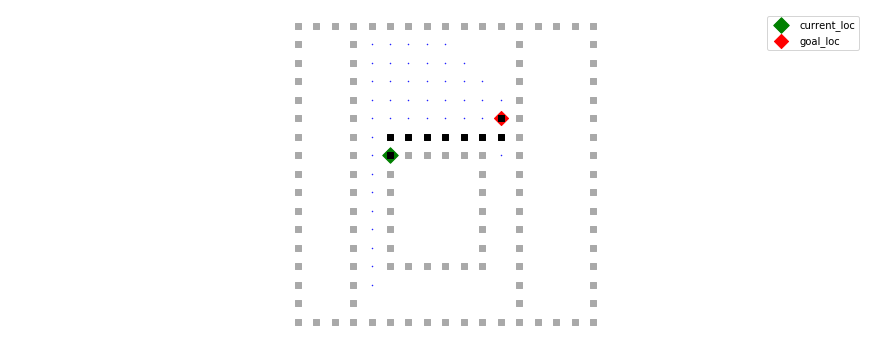

                               Search search: 4.5 path cost, 52 states reached
(3.414, 6.047)
[(3.392, 5.991), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.407, 6.171)


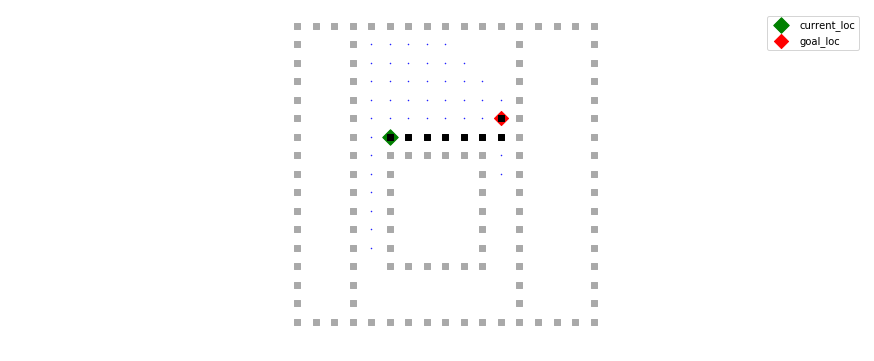

                               Search search: 4.1 path cost, 50 states reached
(3.32, 6.215)
[(3.407, 6.171), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.278, 5.959)


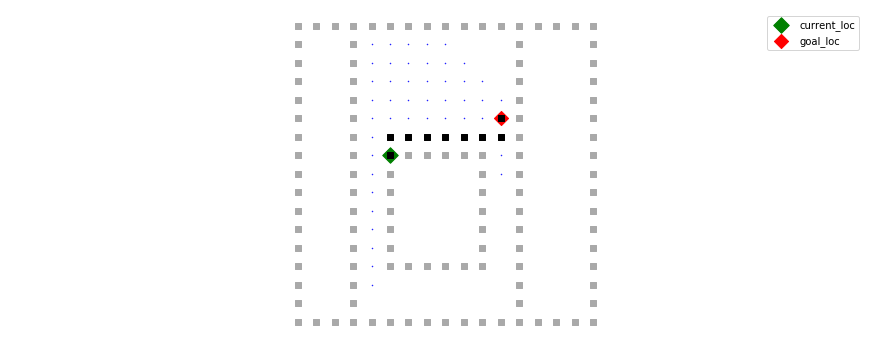

                               Search search: 4.5 path cost, 53 states reached
(3.481, 5.859)
[(3.278, 5.959), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.449, 5.768)


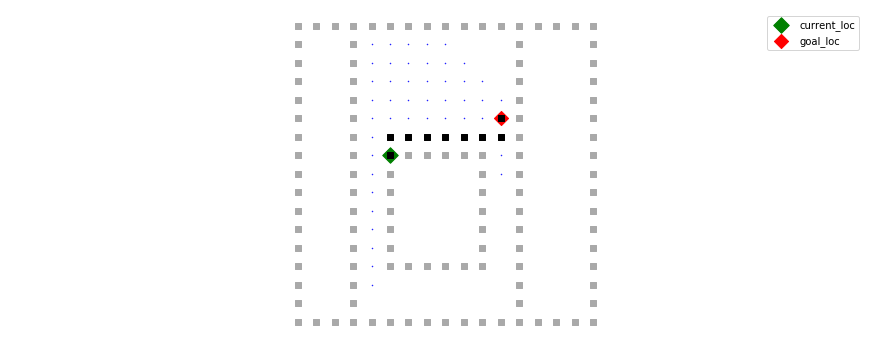

                               Search search: 4.8 path cost, 53 states reached
(3.344, 5.875)
[(3.449, 5.768), (3.3, 6.3), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.461, 6.105)


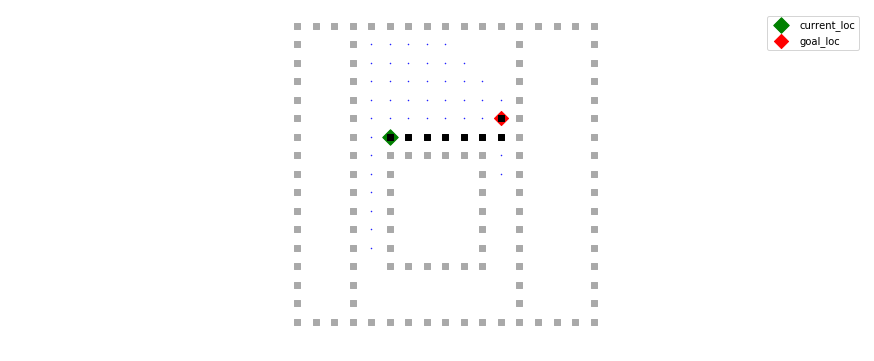

                               Search search: 4.1 path cost, 50 states reached
(3.454, 6.164)
[(3.461, 6.105), (3.9, 6.3), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (3.048, 6.322)


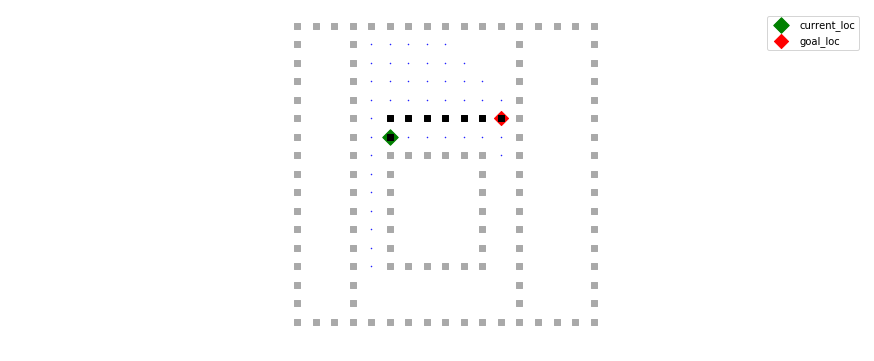

                               Search search: 4.2 path cost, 50 states reached
(3.016, 6.365)
[(3.048, 6.322), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.168, 6.414)


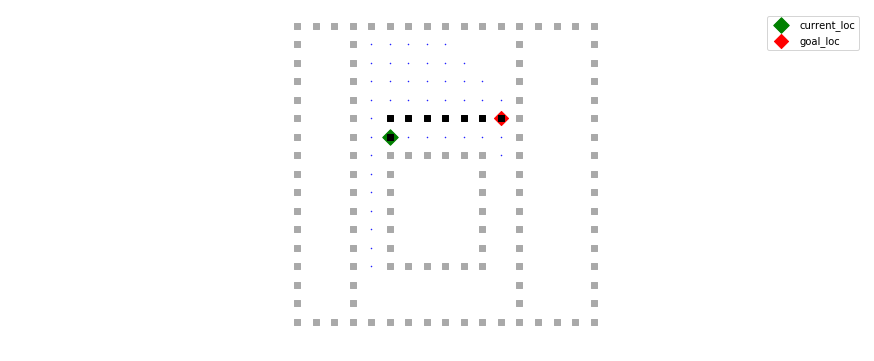

                               Search search: 4.1 path cost, 50 states reached
(3.209, 6.296)
[(3.168, 6.414), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.687, 6.417)


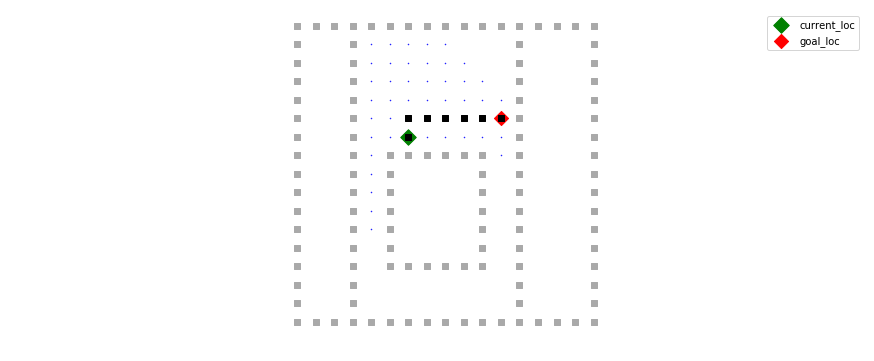

                               Search search: 3.5 path cost, 48 states reached
(3.611, 6.448)
[(3.687, 6.417), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.627, 6.269)


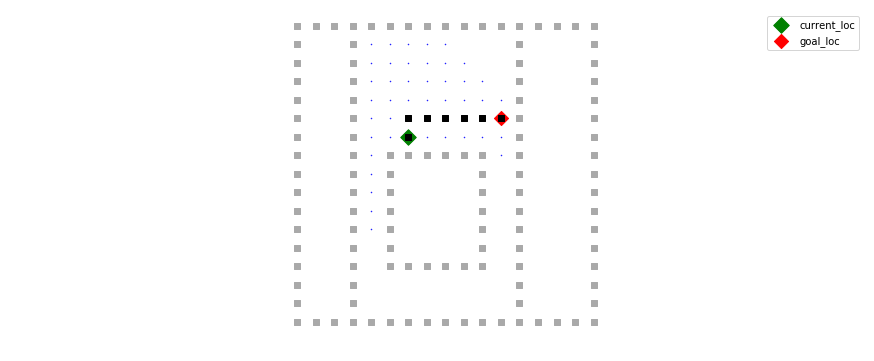

                               Search search: 3.7 path cost, 48 states reached
(3.705, 6.302)
[(3.627, 6.269), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.853, 6.729)


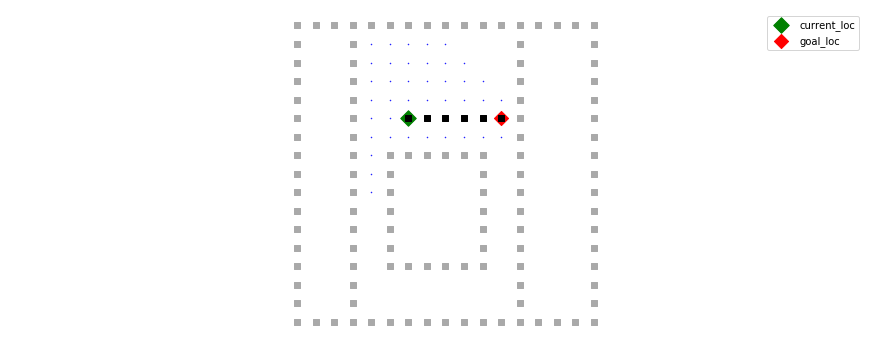

                               Search search: 3.1 path cost, 45 states reached
(3.747, 6.663)
[(3.853, 6.729), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.79, 6.669)


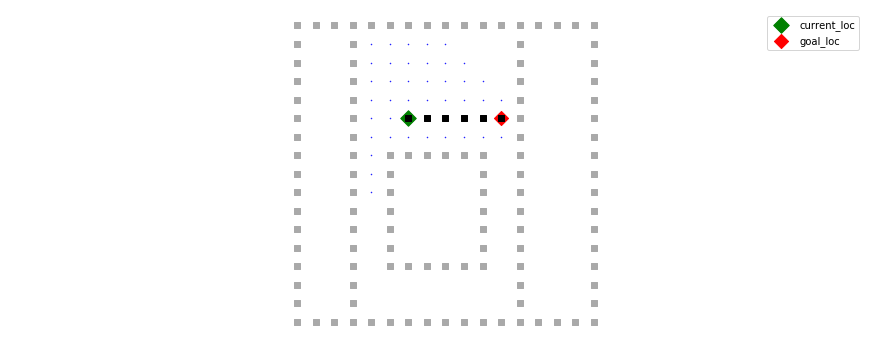

                               Search search: 3.1 path cost, 45 states reached
(3.691, 6.511)
[(3.79, 6.669), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.552, 6.609)


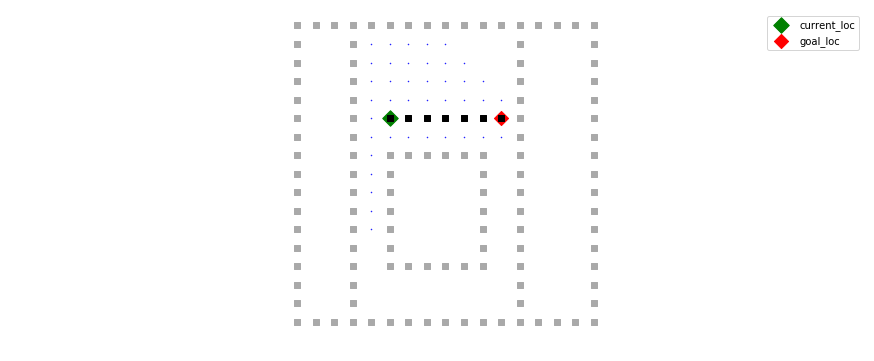

                               Search search: 3.5 path cost, 47 states reached
(3.553, 6.605)
[(3.552, 6.609), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.723, 6.626)


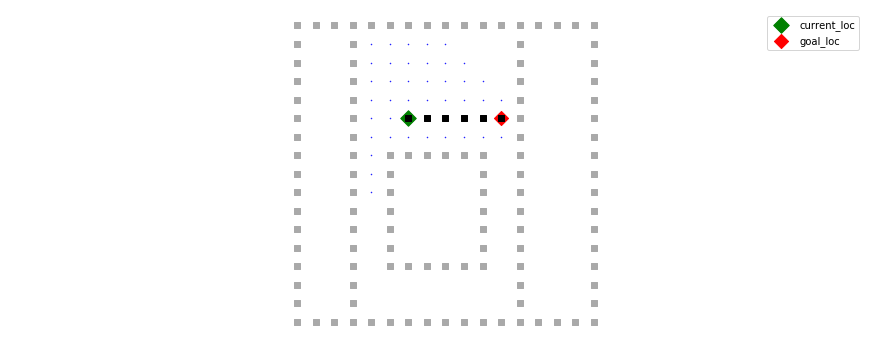

                               Search search: 3.2 path cost, 45 states reached
(3.78, 6.634)
[(3.723, 6.626), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.574, 6.587)


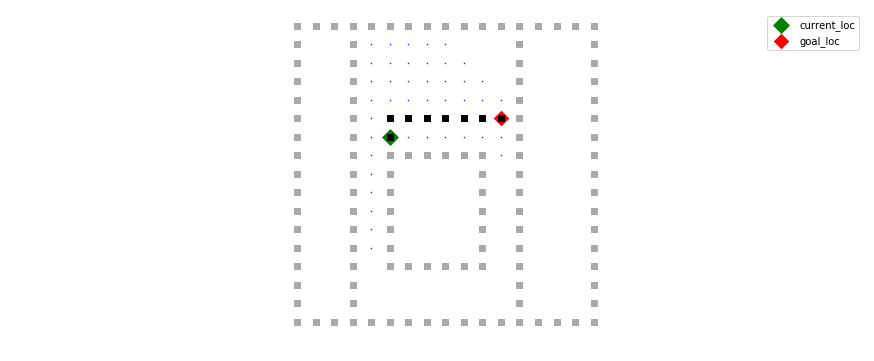

                               Search search: 4.0 path cost, 49 states reached
(3.709, 6.616)
[(3.574, 6.587), (3.3, 6.9), (3.9, 6.9), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.675, 6.712)


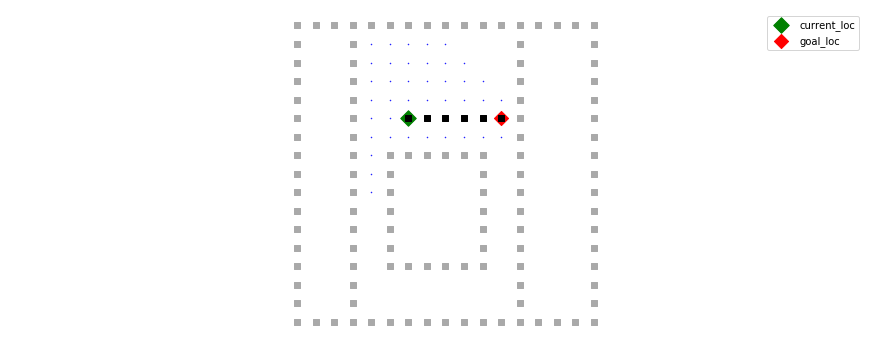

                               Search search: 3.2 path cost, 45 states reached
(3.693, 6.707)
[(3.675, 6.712), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.871, 6.801)


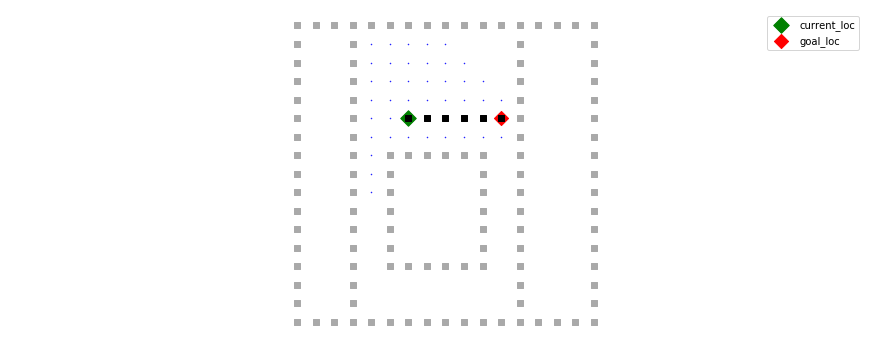

                               Search search: 3.0 path cost, 45 states reached
(3.686, 6.819)
[(3.871, 6.801), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.649, 6.927)


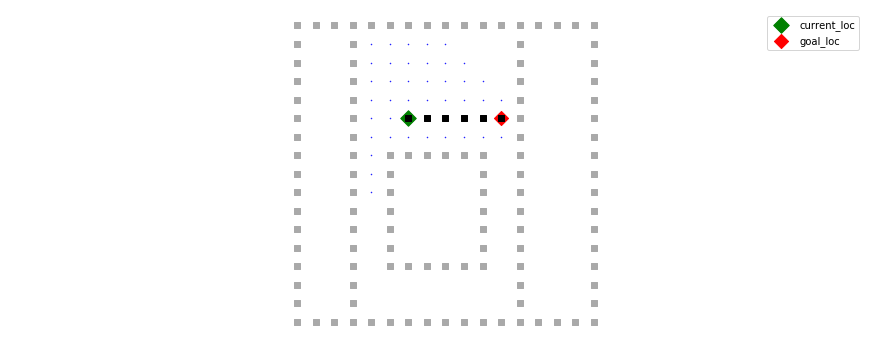

                               Search search: 3.3 path cost, 45 states reached
(3.828, 6.86)
[(3.649, 6.927), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.78, 6.94)


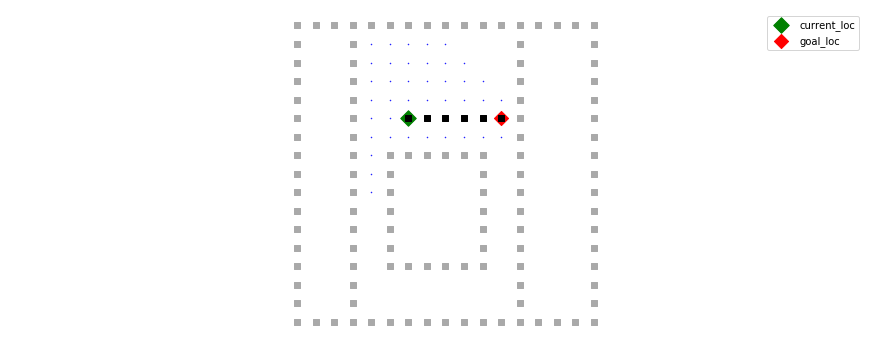

                               Search search: 3.1 path cost, 45 states reached
(3.756, 6.942)
[(3.78, 6.94), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.868, 6.918)


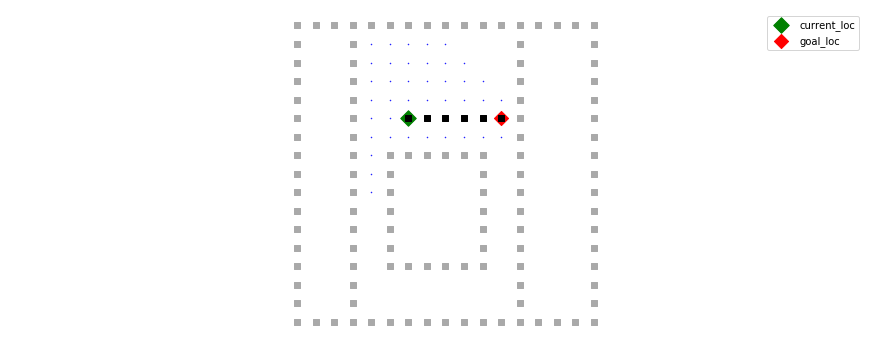

                               Search search: 3.0 path cost, 45 states reached
(3.897, 6.862)
[(3.868, 6.918), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.929, 7.145)


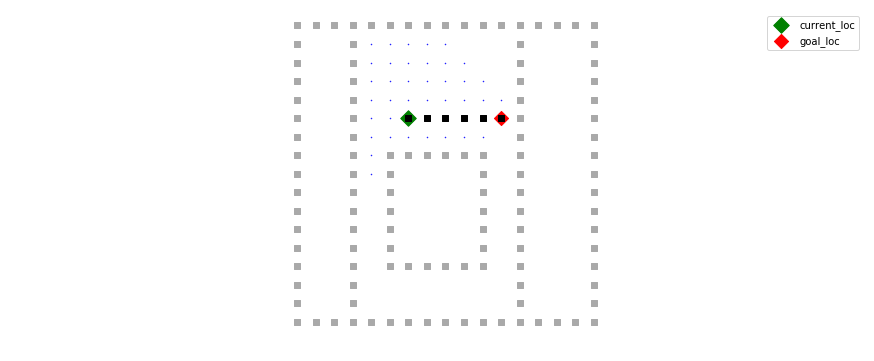

                               Search search: 3.0 path cost, 43 states reached
(3.591, 7.145)
[(3.929, 7.145), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (3.649, 6.818)


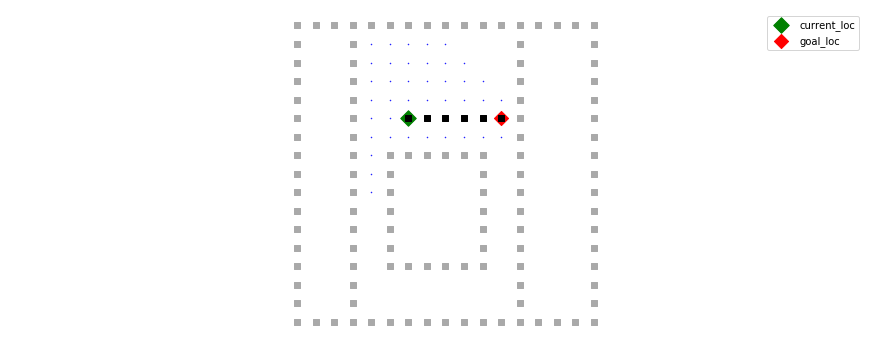

                               Search search: 3.3 path cost, 45 states reached
(3.785, 6.874)
[(3.649, 6.818), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.149, 6.646)


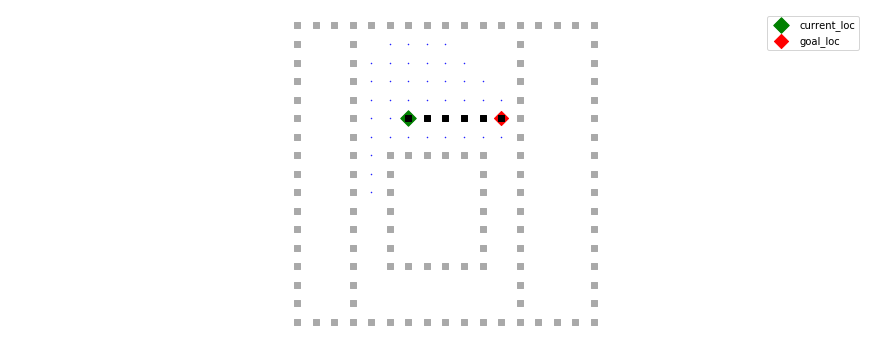

                               Search search: 2.8 path cost, 44 states reached
(3.888, 6.916)
[(4.149, 6.646), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.206, 6.53)


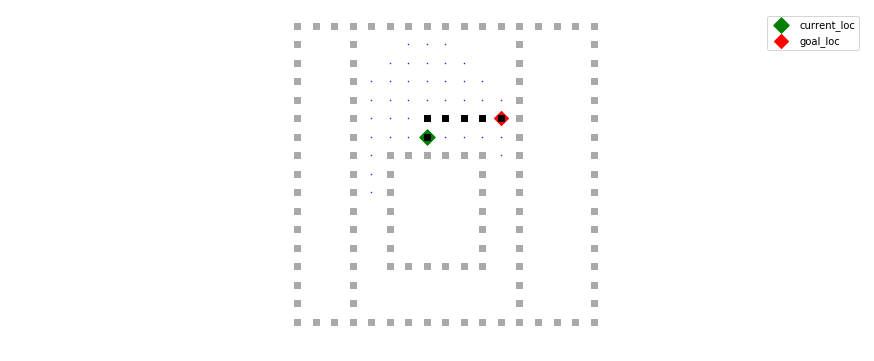

                               Search search: 2.9 path cost, 43 states reached
(4.226, 6.523)
[(4.206, 6.53), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.137, 6.533)


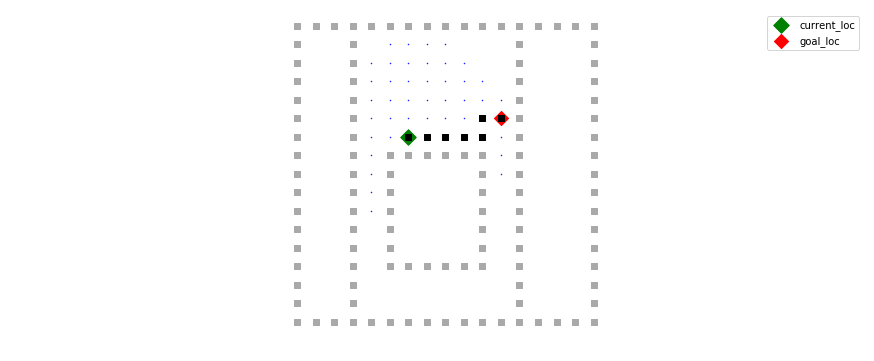

                               Search search: 3.4 path cost, 47 states reached
(4.291, 6.755)
[(4.137, 6.533), (4.5, 6.3), (5.1, 6.3), (5.7, 6.3), (6.3, 6.3), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.353, 6.787)


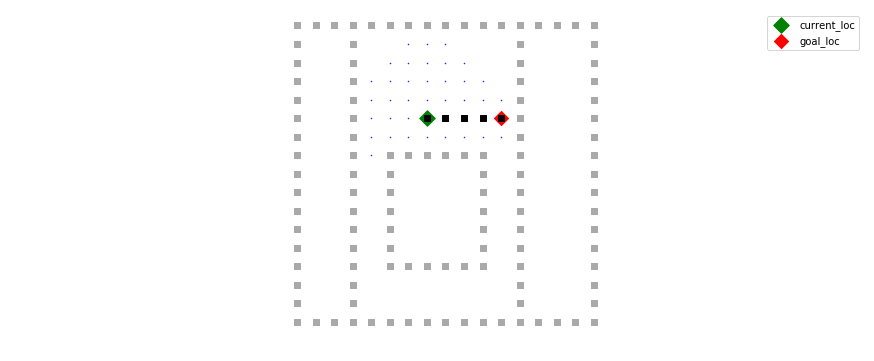

                               Search search: 2.6 path cost, 40 states reached
(4.254, 6.66)
[(4.353, 6.787), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.229, 7.058)


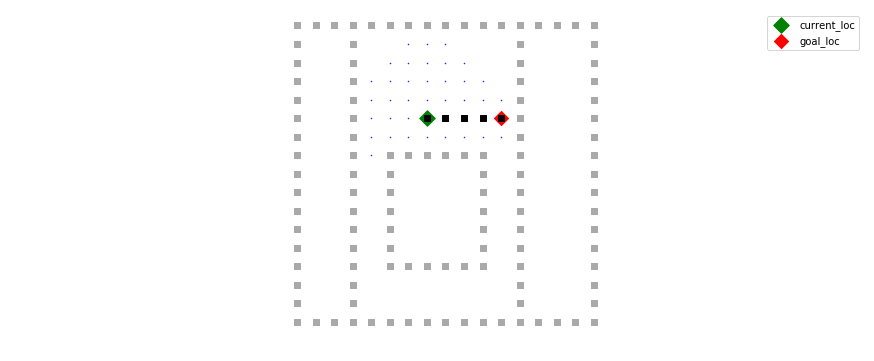

                               Search search: 2.7 path cost, 40 states reached
(4.02, 7.152)
[(4.229, 7.058), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.372, 6.858)


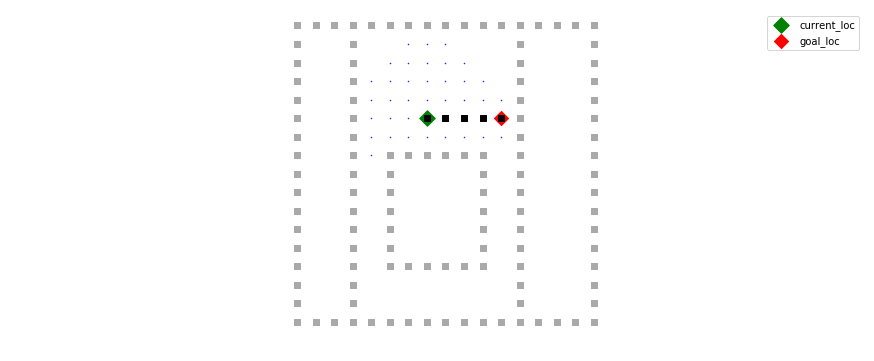

                               Search search: 2.5 path cost, 40 states reached
(4.322, 6.885)
[(4.372, 6.858), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.534, 6.67)


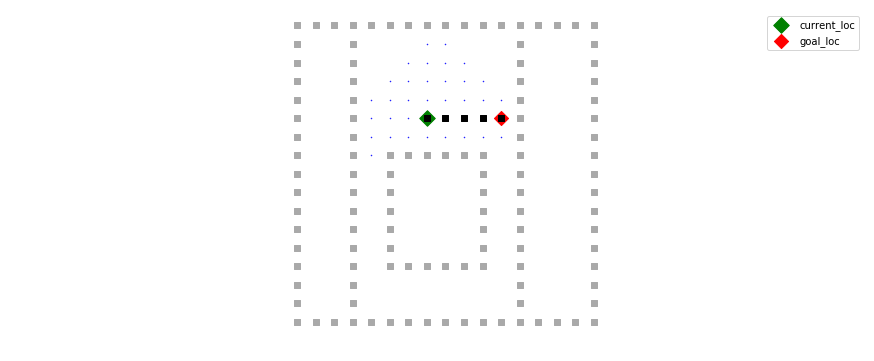

                               Search search: 2.4 path cost, 37 states reached
(4.578, 6.635)
[(4.534, 6.67), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.764, 6.577)


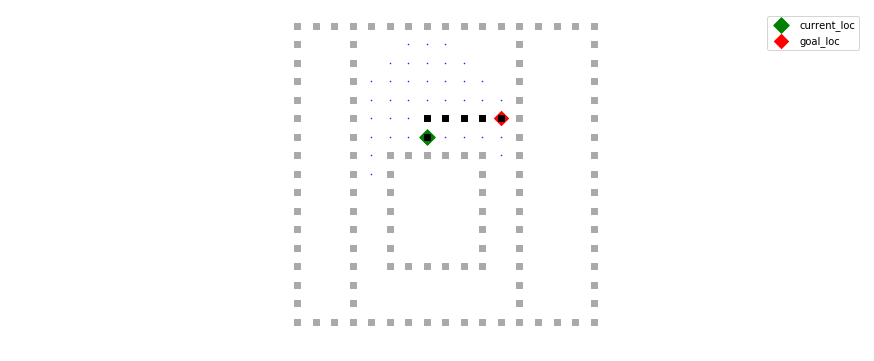

                               Search search: 2.8 path cost, 42 states reached
(4.83, 6.575)
[(4.764, 6.577), (4.5, 6.9), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.827, 6.832)


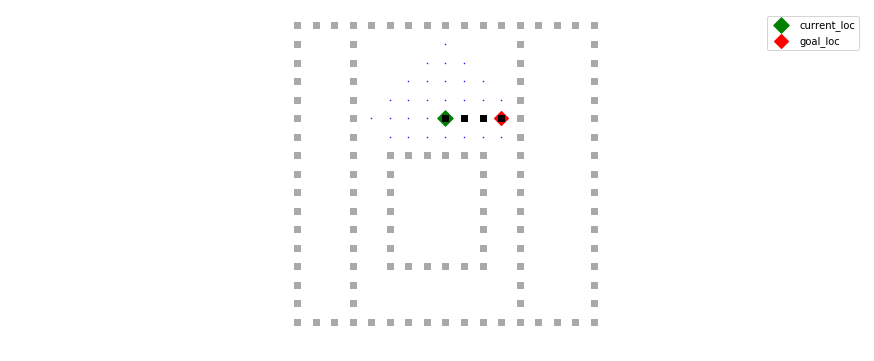

                               Search search: 2.1 path cost, 31 states reached
(4.898, 6.863)
[(4.827, 6.832), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.853, 6.649)


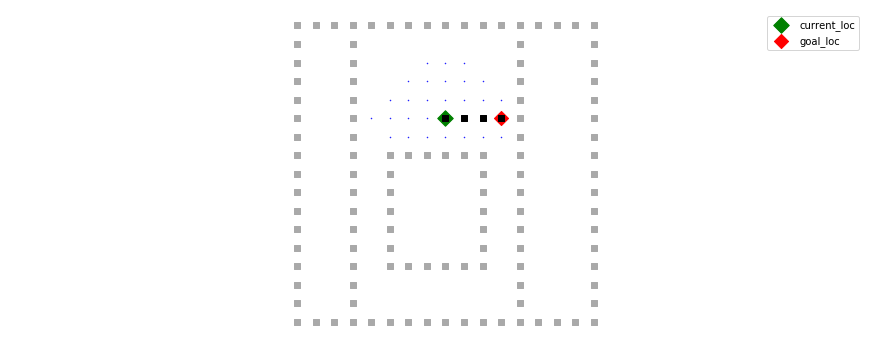

                               Search search: 2.1 path cost, 30 states reached
(4.807, 6.579)
[(4.853, 6.649), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.89, 7.003)


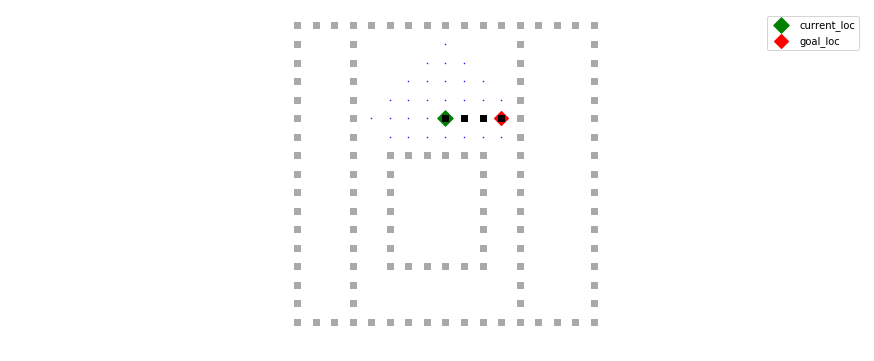

                               Search search: 2.0 path cost, 31 states reached
(4.99, 6.945)
[(4.89, 7.003), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.15, 6.787)


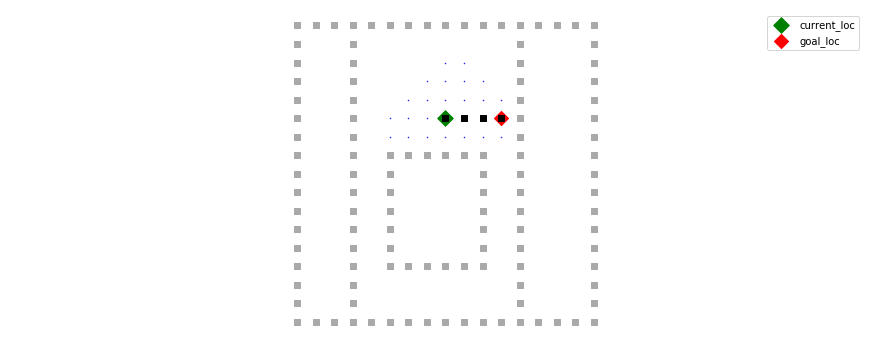

                               Search search: 1.8 path cost, 26 states reached
(5.196, 6.884)
[(5.15, 6.787), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.225, 6.877)


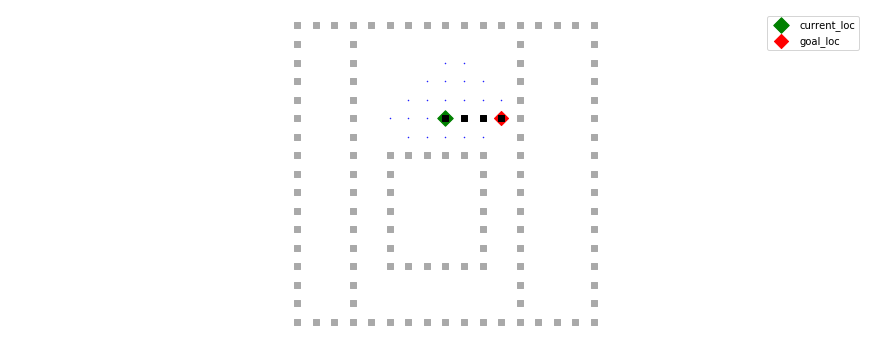

                               Search search: 1.7 path cost, 24 states reached
(5.175, 6.916)
[(5.225, 6.877), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.739, 7.187)


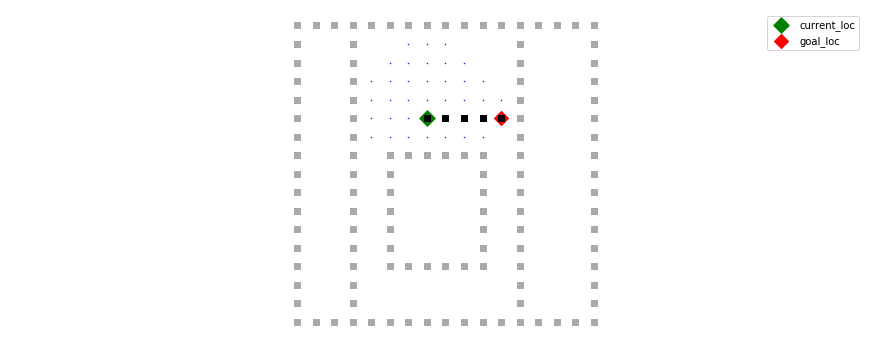

                               Search search: 2.3 path cost, 38 states reached
(5.078, 7.035)
[(4.739, 7.187), (5.1, 6.9), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.36, 6.968)


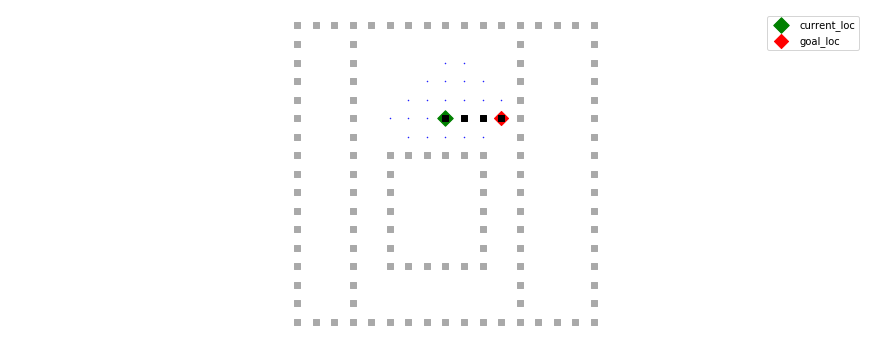

                               Search search: 1.5 path cost, 24 states reached
(5.406, 6.912)
[(5.36, 6.968), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.379, 6.821)


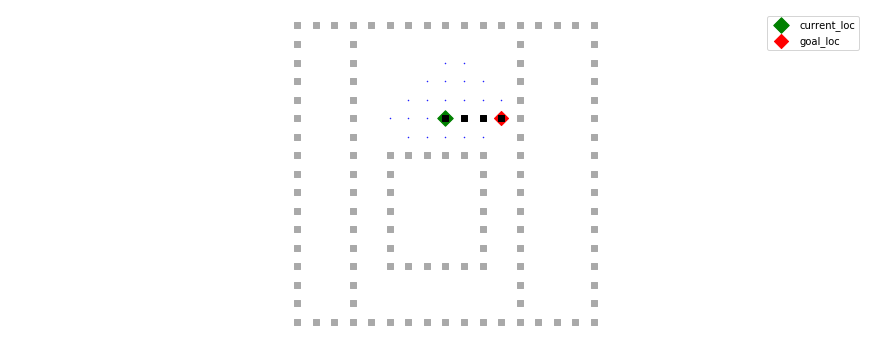

                               Search search: 1.5 path cost, 24 states reached
(5.461, 6.79)
[(5.379, 6.821), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.489, 6.901)


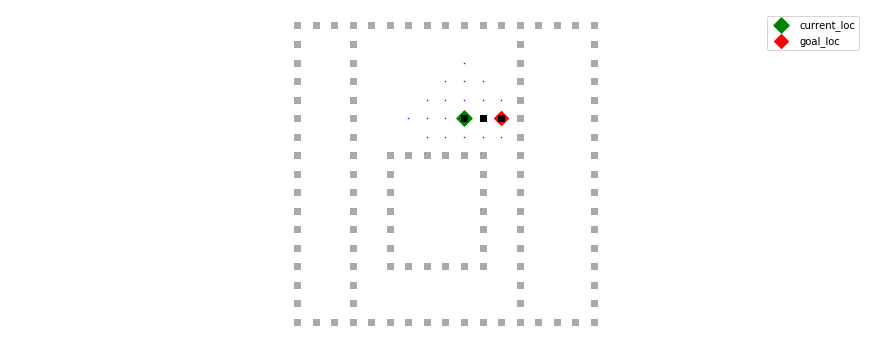

                               Search search: 1.4 path cost, 20 states reached
(5.487, 6.901)
[(5.489, 6.901), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.505, 6.869)


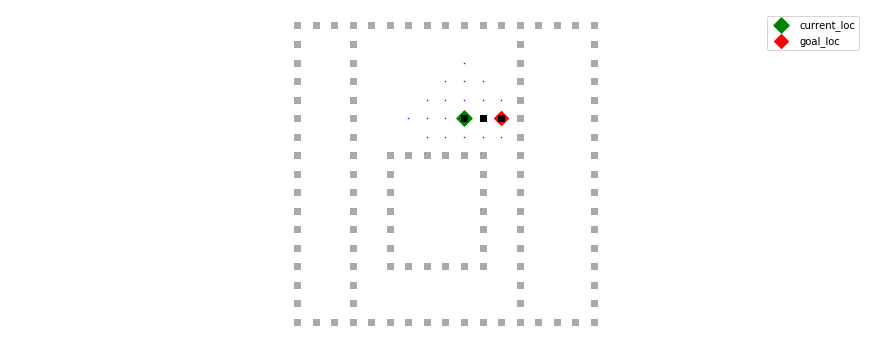

                               Search search: 1.4 path cost, 20 states reached
(5.531, 6.846)
[(5.505, 6.869), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.607, 6.762)


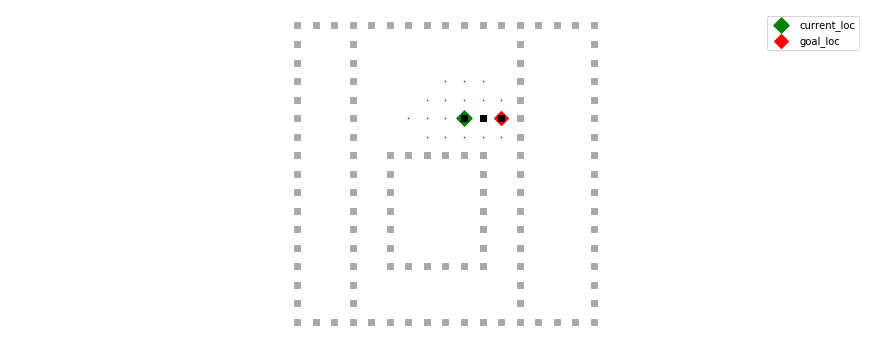

                               Search search: 1.3 path cost, 19 states reached
(5.63, 6.778)
[(5.607, 6.762), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.672, 6.87)


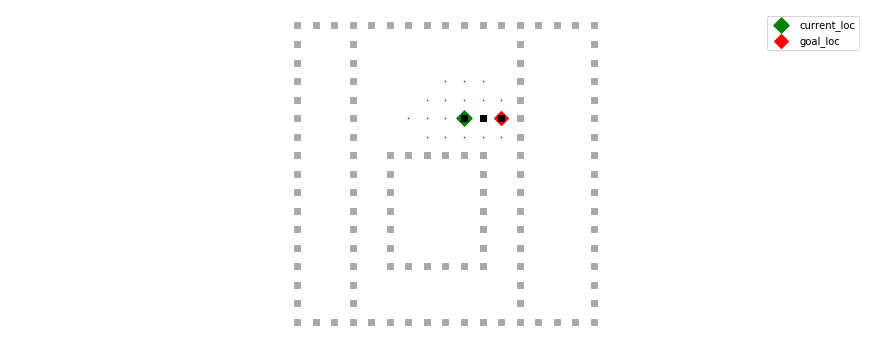

                               Search search: 1.2 path cost, 19 states reached
(5.681, 6.881)
[(5.672, 6.87), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.625, 6.857)


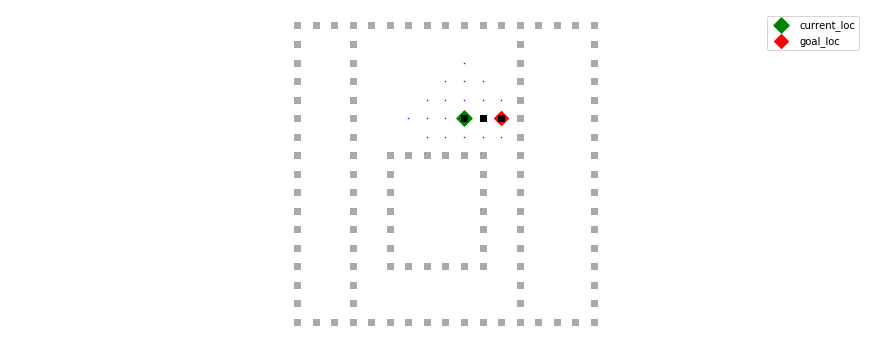

                               Search search: 1.3 path cost, 20 states reached
(5.316, 7.057)
[(5.625, 6.857), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.759, 6.776)


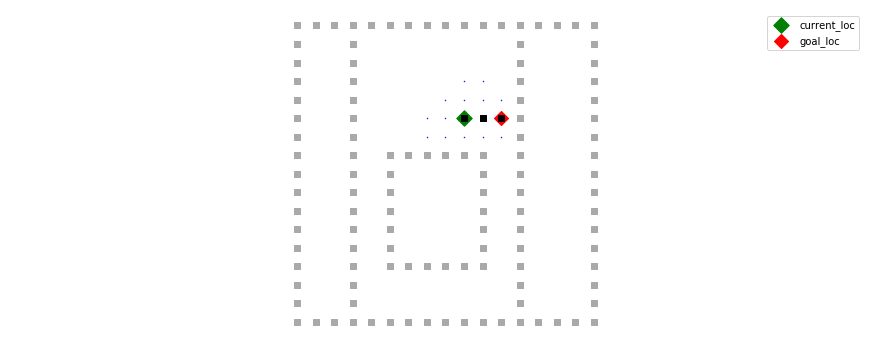

                               Search search: 1.2 path cost, 16 states reached
(5.233, 7.201)
[(5.759, 6.776), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.827, 6.719)


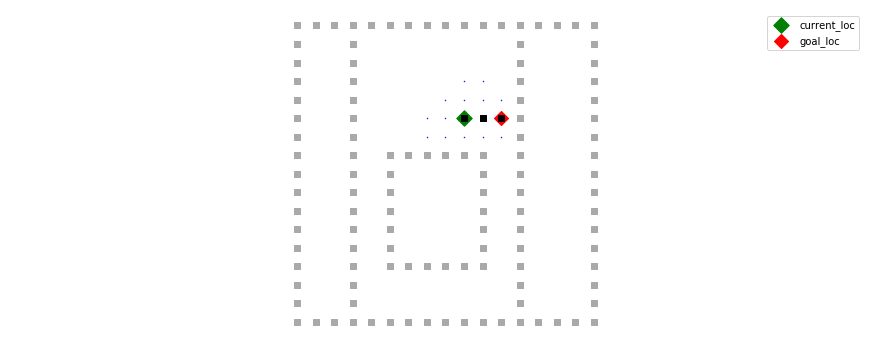

                               Search search: 1.1 path cost, 16 states reached
(5.738, 6.798)
[(5.827, 6.719), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.633, 6.856)


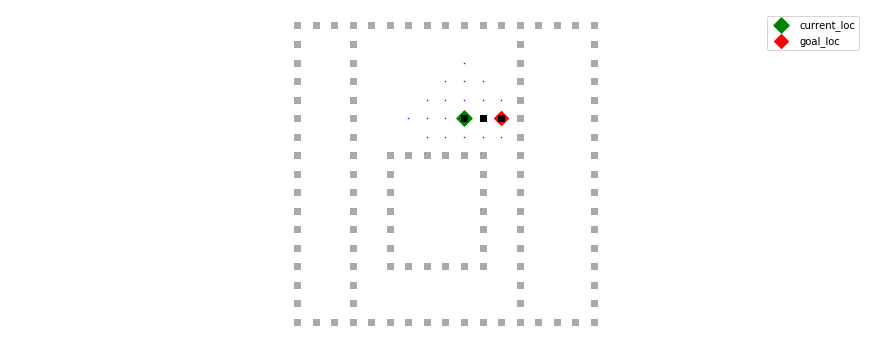

                               Search search: 1.3 path cost, 20 states reached
(5.486, 7.004)
[(5.633, 6.856), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (4.932, 7.122)


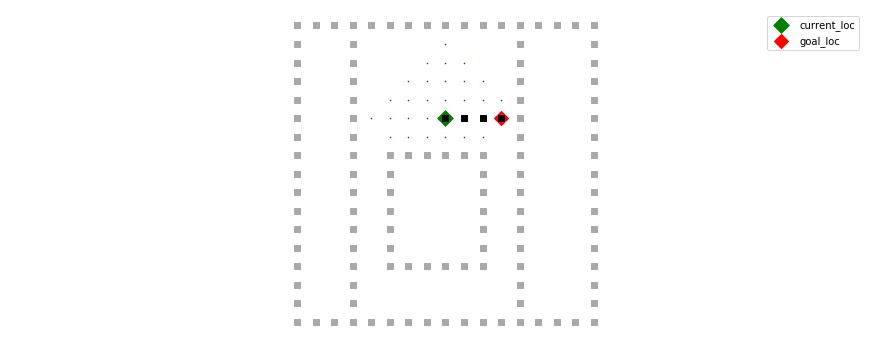

                               Search search: 2.0 path cost, 30 states reached
(4.934, 7.112)
[(4.932, 7.122), (5.7, 6.9), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (5.447, 7.002)


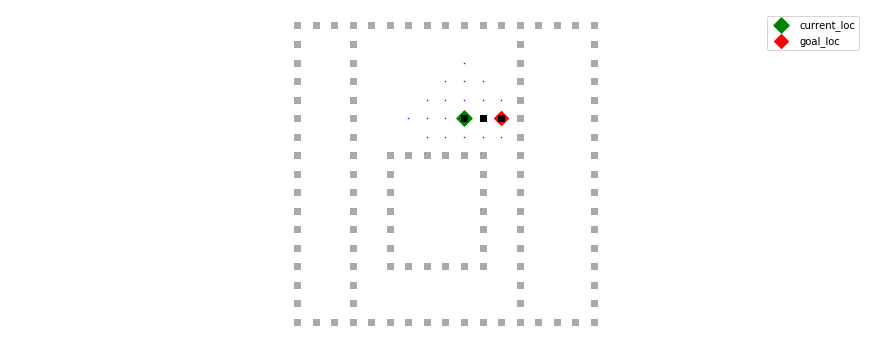

                               Search search: 1.5 path cost, 20 states reached
(6.066, 6.555)
[(5.447, 7.002), (6.3, 6.9), (6.9, 6.9)]
Initial_point: (6.547, 6.235)


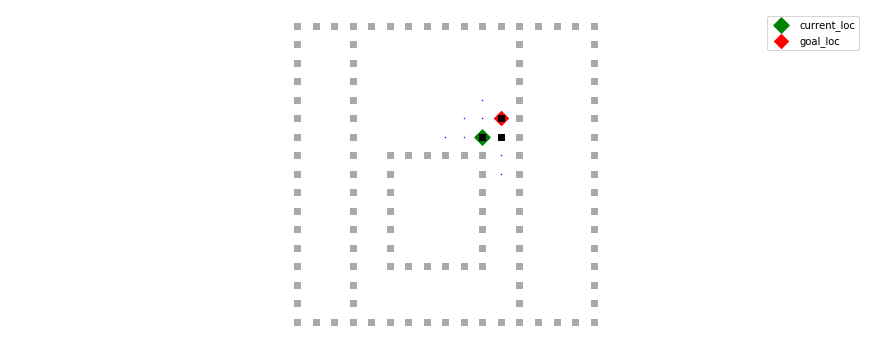

                               Search search: 1.0 path cost, 10 states reached
(6.46, 6.233)
[(6.547, 6.235), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (6.575, 5.648)


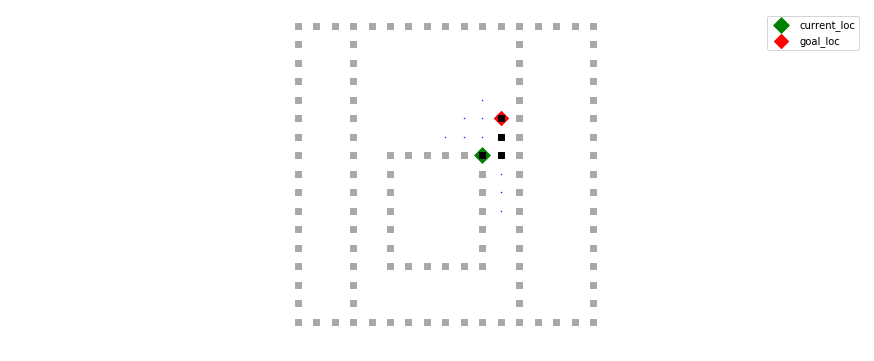

                               Search search: 1.5 path cost, 13 states reached
(6.702, 5.933)
[(6.575, 5.648), (6.9, 5.7), (6.9, 6.3), (6.9, 6.9)]
Initial_point: (6.85, 6.004)


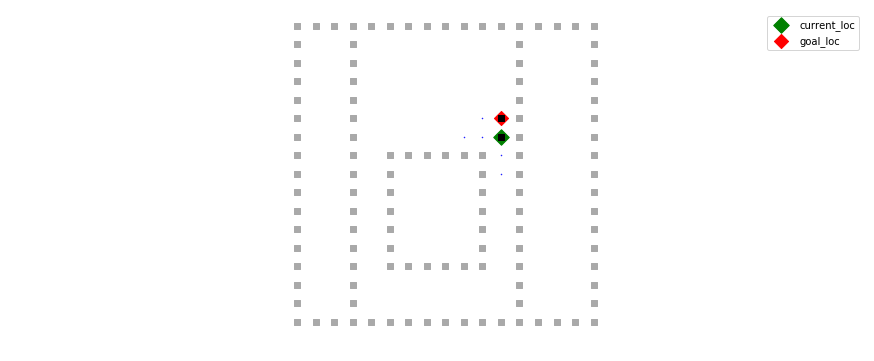

                               Search search: 0.9 path cost, 7 states reached
(6.725, 6.252)
[(6.85, 6.004), (6.9, 6.9)]
Initial_point: (7.197, 6.05)


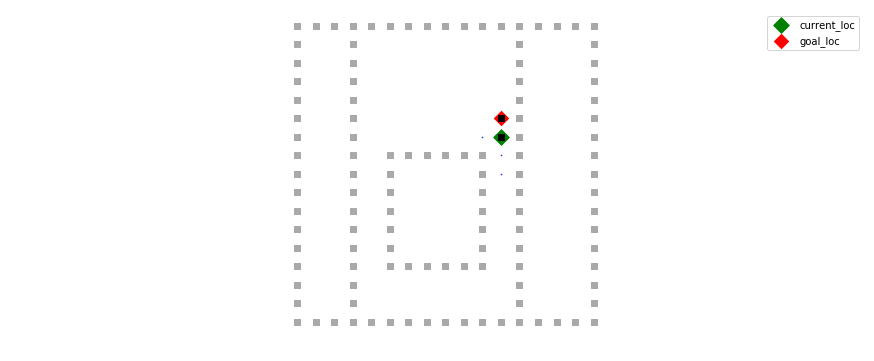

                               Search search: 0.9 path cost, 5 states reached
(7.177, 6.298)
[(7.197, 6.05), (6.9, 6.9)]
Initial_point: (7.117, 6.241)


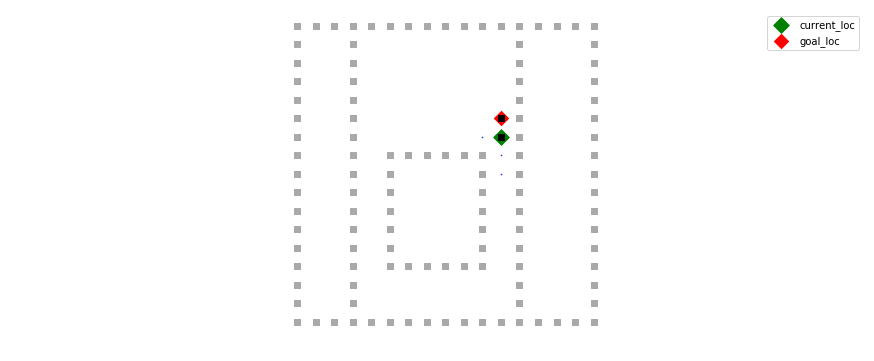

                               Search search: 0.7 path cost, 5 states reached
(7.053, 6.346)
[(7.117, 6.241), (6.9, 6.9)]
Initial_point: (6.296, 7.14)


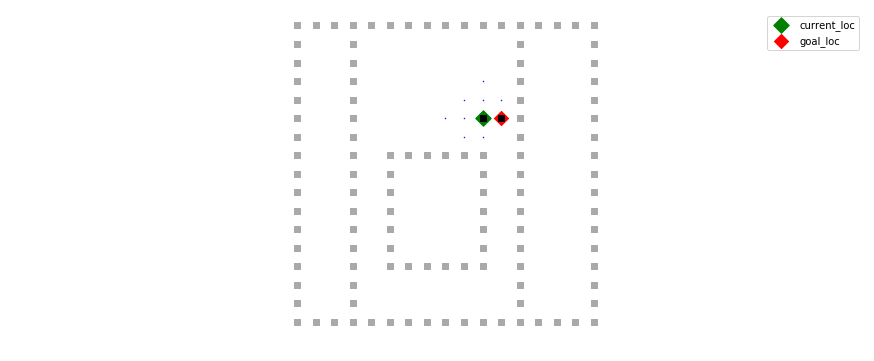

                               Search search: 0.6 path cost, 10 states reached
(6.206, 7.019)
[(6.296, 7.14), (6.9, 6.9)]
Initial_point: (6.952, 6.763)


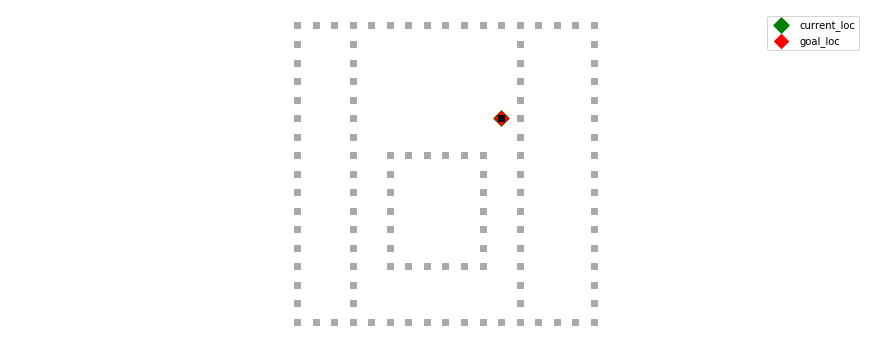

                               Search search: 0.0 path cost, 0 states reached


In [31]:
robot_navigate(goal_point=(7.0, 7.0))